# docplex installation

In [1]:
#%pip install cplex
#%pip install docplex
#python 'setup.py' install

# Imports

In [2]:
import cplex
import docplex.mp as docplex
import pandas as pd
import numpy as np
from docplex.mp.model import Model
from sklearn.preprocessing import OrdinalEncoder
from sklearn.datasets import make_regression
from docplex.cp.model import CpoModel
from sklearn.preprocessing import normalize
from itertools import compress
import time
import seaborn as sns
import math
import matplotlib.pyplot as plt
import plotnine as p9
from plotnine import *
import docplex.cp.parameters as params
import patchworklib as pw 
import random
from numpy import linalg
from numpy.linalg import eig

<Figure size 72x72 with 0 Axes>

# Datasets

## Toy dataset for examples

In [3]:
# Set the random seed for reproducibility
np.random.seed(42)

# Define the number of samples and variables
def generate_data(num_samples, num_variables, num_important):
    # Generate a regression dataset with five important variables
    X, y, coef = make_regression(n_samples=num_samples, n_features=num_important, n_informative=num_important, coef=True)

    # Create additional unimportant variables
    X_additional = np.random.random((num_samples, num_variables - num_important))

    # Concatenate the important and unimportant variables
    X = np.concatenate((X, X_additional), axis=1)

    # Create a DataFrame to store the dataset
    columns = [f'Variable_{i+1}' for i in range(num_variables)]
    df = pd.DataFrame(X, columns=columns)
    return(df, y)


In [4]:
df, y = generate_data(1000, 4, 2)

In [5]:
df3, y3 = generate_data(70, 100, 5)

## Artificial experiments from paper

### Experiment 2

In [6]:
def generate_ex2(n, p, snr=7):
    cov = np.zeros((p, p))
    np.fill_diagonal(cov,1)
    x   = np.random.multivariate_normal([0] * p, cov, n)
    x   = pd.DataFrame(normalize(x, axis=0, norm='l2'))
    b   = [1] * 5 + [0] * (p - 5)
    sd  = np.var(np.dot(x, b)) / snr
    eps = np.random.normal(0, sd, n)
    y   = np.dot(x, b) + eps
    return (x, y)
    

In [7]:
(x_ex2, y_ex2) = generate_ex2(30, 100)
x_ex2.head()

0         1         2         3         4         5         6    
0 -0.039645  0.063926  0.276910  0.066129  0.030967 -0.009703 -0.232508  \
1  0.033067 -0.151687  0.212915  0.245855 -0.007824  0.233746 -0.083403   
2  0.147933 -0.081981 -0.150451  0.199603  0.031760 -0.174628 -0.030015   
3  0.007119  0.013976  0.389107 -0.036968  0.050834 -0.333731 -0.006310   
4 -0.188029  0.012105 -0.010309  0.036218 -0.002828 -0.201291  0.294813   

         7         8         9   ...        90        91        92        93   
0 -0.036841  0.356242 -0.072836  ... -0.163234 -0.077002  0.384941  0.179794  \
1 -0.122264  0.198574  0.306677  ...  0.148953 -0.149038  0.003804 -0.044970   
2 -0.069693 -0.148723  0.196947  ... -0.033131  0.063603  0.289630 -0.176568   
3  0.057199 -0.248202 -0.181302  ...  0.046026  0.233891 -0.216196 -0.006037   
4  0.321900  0.098701  0.116101  ... -0.202576 -0.316166  0.090810  0.398702   

         94        95        96        97        98        99  
0 -0.205110  0.163219  0.104407 -0.021933 -0.125794 -0.167501  
1 -0.142863  0.158128  0.273296  0.211971 -0.123655  0.406229  
2 -0.251344  0.076653 -0.097660 -0.476965 -0.220846 -0.063497  
3 -0.052180 -0.119188  0.040198 -0.021257  0.114311  0.232636  
4  0.439668 -0.160896 -0.045290  0.260304  0.076820  0.027427  

[5 rows x 100 columns]

### Experiment 3

In [8]:
def generate_ex3(n, p, snr=7):
    cov = np.zeros((p, p))
    np.fill_diagonal(cov, 1)
    k   = 10
    x   = np.random.multivariate_normal([0] * p, cov, n)
    x   = pd.DataFrame(normalize(x, axis=0, norm='l2'))
    b   = []
    for i in range(k):
        b.append(0.5 + 9.5 * i / k)
    b   = b + [0] * (p - 10)
    sd  = np.var(np.dot(x, b)) / snr
    eps = np.random.normal(0, sd, n)
    y   = np.dot(x, b) + eps
    return (x, y)


In [9]:
(x_ex3, y_ex3) = generate_ex3(30, 100)
x_ex3.head()

0         1         2         3         4         5         6    
0 -0.011173  0.031108  0.095709 -0.311921  0.147918  0.169916 -0.117733  \
1 -0.060813  0.057183 -0.163224  0.109214 -0.005350 -0.155656  0.080068   
2  0.101269  0.185647  0.313225 -0.121710  0.238941  0.267691 -0.074071   
3 -0.338609 -0.098338  0.228790 -0.222834  0.128799  0.179082  0.369907   
4  0.053094  0.052708  0.117654  0.201762  0.165291  0.120221 -0.189670   

         7         8         9   ...        90        91        92        93   
0  0.245697 -0.373582  0.073951  ... -0.105531 -0.087139 -0.111427  0.057372  \
1 -0.151133 -0.121489 -0.251693  ...  0.301957  0.008717  0.380195  0.106570   
2  0.274132  0.159085  0.239311  ...  0.011851  0.061223  0.322764 -0.027278   
3  0.205064  0.160831  0.077040  ...  0.345440  0.218367  0.012785 -0.089263   
4  0.234290  0.137956 -0.053594  ... -0.195668 -0.019295  0.041934 -0.034877   

         94        95        96        97        98        99  
0  0.243686 -0.048980 -0.163142  0.164202 -0.051060  0.015641  
1 -0.099083  0.191104 -0.048596  0.050742 -0.241997 -0.219860  
2 -0.017712 -0.344150 -0.029424  0.053398 -0.138032 -0.146876  
3  0.110137  0.127863  0.050931 -0.205049 -0.037953  0.011369  
4  0.044469  0.129390  0.154642  0.173180  0.182050  0.072441  

[5 rows x 100 columns]

### Experiment 4

In [10]:
def generate_ex4(n, p, snr=7):
    cov = np.zeros((p, p))
    np.fill_diagonal(cov,1)
    x   = np.random.multivariate_normal([0] * p, cov, n)
    x   = pd.DataFrame(normalize(x, axis=0, norm='l2'))
    k   = 6
    b   = [-10, -6, -2, 2, 6, 10] + [0] * (p - 6)
    sd  = np.var(np.dot(x, b)) / snr
    eps = np.random.normal(0, sd, n)
    y   = np.dot(x, b) + eps
    return (x, y)
    

In [11]:
(x_ex4, y_ex4) = generate_ex4(30, 100)
x_ex4.head()

0         1         2         3         4         5         6    
0 -0.070822 -0.328884 -0.037421  0.218896 -0.076393 -0.187245  0.119007  \
1  0.022547 -0.088232 -0.163698  0.225542  0.043188 -0.264171 -0.094209   
2  0.159389  0.016692  0.235248  0.472168 -0.183920 -0.433483  0.064864   
3 -0.417632  0.266245 -0.094531  0.223312 -0.145109  0.054056  0.010371   
4 -0.079029 -0.193509 -0.047867 -0.157023 -0.119928 -0.440980 -0.328470   

         7         8         9   ...        90        91        92        93   
0  0.061079 -0.000614  0.083974  ...  0.015677  0.228375 -0.043004  0.120783  \
1  0.221965 -0.178675 -0.168077  ...  0.143045  0.253215  0.388788  0.005000   
2  0.255874 -0.324162  0.146564  ...  0.144253  0.218404  0.010358 -0.065288   
3 -0.142294  0.100476  0.224743  ... -0.291134  0.033365  0.363588 -0.139488   
4  0.079592  0.264432  0.568449  ...  0.061476 -0.298769 -0.053659  0.425336   

         94        95        96        97        98        99  
0  0.107406 -0.181829  0.239308  0.021263  0.163341 -0.268881  
1  0.136236 -0.139159 -0.183884 -0.279659  0.065362  0.261353  
2  0.151451  0.149638  0.024613  0.134307 -0.102275 -0.004965  
3 -0.151888 -0.045620  0.325274 -0.274116  0.129019 -0.097334  
4 -0.045784  0.301944 -0.198228 -0.059003 -0.036151  0.403221  

[5 rows x 100 columns]

In [12]:
x_ex4.iloc[:5,:6]

0         1         2         3         4         5
0 -0.070822 -0.328884 -0.037421  0.218896 -0.076393 -0.187245
1  0.022547 -0.088232 -0.163698  0.225542  0.043188 -0.264171
2  0.159389  0.016692  0.235248  0.472168 -0.183920 -0.433483
3 -0.417632  0.266245 -0.094531  0.223312 -0.145109  0.054056
4 -0.079029 -0.193509 -0.047867 -0.157023 -0.119928 -0.440980

In [13]:
y_ex4

array([-0.21451675, -1.79014807, -5.4985124 ,  3.73327493, -3.94898732,
       -0.09329389, -0.08454577,  1.31743239, -3.41974552,  1.63949837,
       -2.15759187, -0.85250249,  0.66651869, -0.84931499,  0.33235618,
       -2.1692488 , -1.93805906,  1.0316871 ,  4.21103104, -0.95913943,
        1.66050018, -3.541258  ,  0.18983013,  5.15457485, -0.55237539,
        3.1566257 , -3.03153521, -3.43717141, -0.87700497,  1.04503562])

# Helpful functions

## Norms

In [14]:
def norm2_2(x):
    x = [i ** 2 for i in x]
    return sum(x)

def inf_pnorm(x, model):
    return model.max(x)

def pnorm(x, p, model):
    if p == 1:
        x = [model.abs(i) for i in x] # it adds more variables
        x = sum(x)     
    return x  


# Problem formulations

## Basic formulation Z1

![basic formulation](images/basic_formulation.png)

### Code

In [15]:
def basic_form(X, y, Mu, k):
    # Getting the number of columns
    p = X.shape[1]

    # Creating one model instance, with a name
    m = Model(name='basic_form')
    # Setting the k binary variables called z
    z = m.binary_var_list(p, name = 'z')
    # Setting the k binary variables called Beta
    Beta = m.continuous_var_list(p, name  = 'beta')

    # Setting the constraints
    const1_a = m.add_constraints([-Mu*z[i] <= Beta[i] for i in range(p)])
    const1_b = m.add_constraints([Beta[i] <= Mu*z[i]  for i in range(p)])
    #const2   = m.add_constraints(z[i] in [0, 1] for i in range(p))
    const3   = m.add_constraint(sum(z) <= k)


    m.minimize(norm2_2( (y - X @ Beta) )/2)
    m.solve()
    return(m)
    

### Examples

In [16]:
basic_df3 = basic_form(X=df3, y=y3, Mu=10, k = 5)
basic_df3.print_solution()
basic_df3.print_information()
basic_df3.export_as_lp()

objective: 341589.509
status: OPTIMAL_SOLUTION(2)
  z_0=1
  z_1=1
  z_2=1
  z_3=1
  z_4=1
  beta_0=10.000
  beta_1=10.000
  beta_2=10.000
  beta_3=10.000
  beta_4=10.000
Model: basic_form
 - number of variables: 200
   - binary=100, integer=0, continuous=100
 - number of constraints: 201
   - linear=201
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP


'C:\\Users\\Hubert\\AppData\\Local\\Temp\\basic_form.lp'

## Formulation Z2
![z2 formulation](images/z2_formulation.png)
![p-norm](images/p-norm.png)

### Code

In [17]:
def form_z2(X, y, Mu, k):
    # Getting the number of columns
    p = X.shape[1]

    # Creating one model instance, with a name
    m = Model(name='basic_form')
    # Setting the k binary variables called Beta
    Beta = m.continuous_var_list(p, name  = 'beta')

    # Setting the constraints
    const1_a = m.add_constraint(inf_pnorm(Beta, m) <= Mu)
    const1_b = m.add_constraint(pnorm(Beta, 1, m) <= Mu * k) # we basically double the number of beta variables here


    m.minimize(norm2_2( (y - X @ Beta) ) / 2)
    m.solve()
    return(m)
    

### Examples

In [18]:
z2_df3 = form_z2(X=df3, y=y3, Mu=5, k = 5)
z2_df3.print_solution()
z2_df3.print_information()
z2_df3.export_as_lp()

objective: 407258.501
status: OPTIMAL_SOLUTION(2)
  beta_0=5.000
  beta_1=5.000
  beta_2=5.000
  beta_3=5.000
  beta_4=5.000
Model: basic_form
 - number of variables: 501
   - binary=100, integer=0, continuous=401
 - number of constraints: 403
   - linear=303, indicator=100
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP


'C:\\Users\\Hubert\\AppData\\Local\\Temp\\basic_form.lp'

## Formulation Z3

![z3 formulation](images/z3_formulation.png)

### Code

In [19]:
def form_z3(X, y, Mu, k):
    # Getting the number of columns
    p = X.shape[1]

    # Creating one model instance, with a name
    m = Model(name='basic_form')
    # Setting the k binary variables called Beta
    Beta = m.continuous_var_list(p, name  = 'beta')

    # Setting the constraints
    const1_b = m.add_constraint(pnorm(Beta, 1, m) <= Mu * k) # we basically double the number of beta variables here


    m.minimize(norm2_2( (y - X @ Beta) )/2)
    m.solve()
    return(m)
    

### Examples

In [20]:
z3_df3 = form_z3(X=df3, y=y3, Mu=100, k = 5)
z3_df3.print_solution()
z3_df3.print_information()
z3_df3.export_as_lp()

objective: 0.000
status: OPTIMAL_SOLUTION(2)
  beta_0=29.482
  beta_1=98.409
  beta_2=40.547
  beta_3=35.455
  beta_4=29.225
Model: basic_form
 - number of variables: 400
   - binary=0, integer=0, continuous=400
 - number of constraints: 201
   - linear=201
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP


'C:\\Users\\Hubert\\AppData\\Local\\Temp\\basic_form.lp'

## SOS formulation 1

![sos formulation 1](images/sos_formulation_1.png)

### Code

In [21]:
def sos_1_form(X, y, k):
    # Getting the number of columns
    p = X.shape[1]

    # Creating one model instance, with a name
    m = Model(name='basic_form')
    # Setting the k binary variables called z
    z = m.binary_var_list(p, name = 'z')
    # Setting the k binary variables called Beta
    Beta = m.continuous_var_list(p, name  = 'beta')

    z2 = m.binary_var_list(p, name = 'z2')
    for i in range(p):
        m.add_if_then(z[i] == 0, z2[i] == 1)
        m.add_if_then(z[i] == 1, z2[i] == 0)

    # Setting the constraints
    for i in range(p):
        const1   = m.add_sos(sos_arg = 1, dvars = [Beta[i], z2[i]], name = 'sos') #SOS1 - at most one element can be zero
    const3   = m.add_constraint(sum(z) <= k)


    m.minimize(norm2_2( (y - X @ Beta) ) / 2)
    m.solve()
    return(m)

### Examples

In [22]:
z3_df3 = sos_1_form(X=df3, y=y3, k = 5)
z3_df3.print_solution()
z3_df3.print_information()
z3_df3.export_as_lp()

objective: 0.000
status: OPTIMAL_SOLUTION(2)
  z_0=1
  z_1=1
  z_2=1
  z_3=1
  z_4=1
  beta_0=29.482
  beta_1=98.409
  beta_2=40.547
  beta_3=35.455
  beta_4=29.225
  z2_5=1
  z2_6=1
  z2_7=1
  z2_8=1
  z2_9=1
  z2_10=1
  z2_11=1
  z2_12=1
  z2_13=1
  z2_14=1
  z2_15=1
  z2_16=1
  z2_17=1
  z2_18=1
  z2_19=1
  z2_20=1
  z2_21=1
  z2_22=1
  z2_23=1
  z2_24=1
  z2_25=1
  z2_26=1
  z2_27=1
  z2_28=1
  z2_29=1
  z2_30=1
  z2_31=1
  z2_32=1
  z2_33=1
  z2_34=1
  z2_35=1
  z2_36=1
  z2_37=1
  z2_38=1
  z2_39=1
  z2_40=1
  z2_41=1
  z2_42=1
  z2_43=1
  z2_44=1
  z2_45=1
  z2_46=1
  z2_47=1
  z2_48=1
  z2_49=1
  z2_50=1
  z2_51=1
  z2_52=1
  z2_53=1
  z2_54=1
  z2_55=1
  z2_56=1
  z2_57=1
  z2_58=1
  z2_59=1
  z2_60=1
  z2_61=1
  z2_62=1
  z2_63=1
  z2_64=1
  z2_65=1
  z2_66=1
  z2_67=1
  z2_68=1
  z2_69=1
  z2_70=1
  z2_71=1
  z2_72=1
  z2_73=1
  z2_74=1
  z2_75=1
  z2_76=1
  z2_77=1
  z2_78=1
  z2_79=1
  z2_80=1
  z2_81=1
  z2_82=1
  z2_83=1
  z2_84=1
  z2_85=1
  z2_86=1
  z2_87=1
  z2_88=1


'C:\\Users\\Hubert\\AppData\\Local\\Temp\\basic_form.lp'

## SOS formulation 2
![sos formulation 2](images/sos_formulation_2.png)

### Code

In [23]:
def sos_2_form(X, y, Mu, Ml, k, time_limit = None):
    # Getting the number of columns
    p = X.shape[1]

    # Creating one model instance, with a name
    m = Model(name='basic_form')
    # time limit
    if (time_limit != None):
        m.set_time_limit(time_limit)
    # Setting the k binary variables called z
    z = m.binary_var_list(p, name = 'z')
    # Setting the k binary variables called Beta
    Beta = m.continuous_var_list(p, name  = 'beta')

    z2 = m.binary_var_list(p, name = 'z2')
    for i in range(p):
        m.add_if_then(z[i] == 0, z2[i] == 1)
        m.add_if_then(z[i] == 1, z2[i] == 0)
        
    # Setting the constraints
    for i in range(p):
        const1   = m.add_sos(sos_arg = 1, dvars = [Beta[i], z2[i]], name = 'sos') #SOS1 - at most one element can be zero
    const3   = m.add_constraint(sum(z) <= k)
    const4_a = m.add_constraints([-Mu <= Beta[i] for i in range(p)])
    const4_b = m.add_constraints([Beta[i] <= Mu  for i in range(p)])
    const5   = m.add_constraint(pnorm(Beta, 1, m) <= Ml)

    m.minimize((np.transpose(Beta) @ (np.transpose(X) @ X) @ Beta)/2 - sum((np.transpose(X) @ y) * np.transpose(Beta)) + norm2_2(y)/2) # second term is the inner product
    m.solve()
    return(m)

### Examples

In [24]:
sos2_df3 = sos_2_form(X=df3, y=y3, Mu=1000, Ml = 1000, k = 5)
sos2_df3.print_solution()
sos2_df3.print_information()
sos2_df3.export_as_lp()

objective: 0.000
status: OPTIMAL_SOLUTION(2)
  z_0=1
  z_1=1
  z_2=1
  z_3=1
  z_4=1
  beta_0=29.482
  beta_1=98.409
  beta_2=40.547
  beta_3=35.455
  beta_4=29.225
  z2_5=1
  z2_6=1
  z2_7=1
  z2_8=1
  z2_9=1
  z2_10=1
  z2_11=1
  z2_12=1
  z2_13=1
  z2_14=1
  z2_15=1
  z2_16=1
  z2_17=1
  z2_18=1
  z2_19=1
  z2_20=1
  z2_21=1
  z2_22=1
  z2_23=1
  z2_24=1
  z2_25=1
  z2_26=1
  z2_27=1
  z2_28=1
  z2_29=1
  z2_30=1
  z2_31=1
  z2_32=1
  z2_33=1
  z2_34=1
  z2_35=1
  z2_36=1
  z2_37=1
  z2_38=1
  z2_39=1
  z2_40=1
  z2_41=1
  z2_42=1
  z2_43=1
  z2_44=1
  z2_45=1
  z2_46=1
  z2_47=1
  z2_48=1
  z2_49=1
  z2_50=1
  z2_51=1
  z2_52=1
  z2_53=1
  z2_54=1
  z2_55=1
  z2_56=1
  z2_57=1
  z2_58=1
  z2_59=1
  z2_60=1
  z2_61=1
  z2_62=1
  z2_63=1
  z2_64=1
  z2_65=1
  z2_66=1
  z2_67=1
  z2_68=1
  z2_69=1
  z2_70=1
  z2_71=1
  z2_72=1
  z2_73=1
  z2_74=1
  z2_75=1
  z2_76=1
  z2_77=1
  z2_78=1
  z2_79=1
  z2_80=1
  z2_81=1
  z2_82=1
  z2_83=1
  z2_84=1
  z2_85=1
  z2_86=1
  z2_87=1
  z2_88=1


'C:\\Users\\Hubert\\AppData\\Local\\Temp\\basic_form.lp'

## SOS formulation 3
![sos formulation 3](images/sos_formulation_3.png)

### Code

In [25]:
def sos_3_form(X, y, Mu, Ml, Mu_ksi, Ml_ksi, k, time_limit = None):
    # Getting the number of columns
    p = X.shape[1]
    n = X.shape[0]
    # Creating one model instance, with a name
    m = Model(name='basic_form')
    # time limit
    if (time_limit != None):
        m.set_time_limit(time_limit)
    # Setting the k binary variables called z
    z = m.binary_var_list(p, name = 'z')
    # Setting the k binary variables called Beta
    Beta = m.continuous_var_list(p, name  = 'beta')
    ksi = X @ Beta
    # Setting the constraints
    z2 = m.binary_var_list(p, name = 'z2')
    for i in range(p):
        m.add_if_then(z[i] == 0, z2[i] == 1)
        m.add_if_then(z[i] == 1, z2[i] == 0)
        
    # Setting the constraints
    for i in range(p):
        const2   = m.add_sos(sos_arg = 1, dvars = [Beta[i], z2[i]], name = 'sos') #SOS1 - at most one element can be zero
    const4   = m.add_constraint(sum(z) <= k)
    const5_a = m.add_constraints([-Mu <= Beta[i] for i in range(p)])
    const5_b = m.add_constraints([Beta[i] <= Mu  for i in range(p)])
    const6   = m.add_constraint(pnorm(Beta, 1, m) <= Ml)
    const7_a = m.add_constraints([-Mu_ksi <= ksi[i] for i in range(n)])
    const7_b = m.add_constraints([ksi[i] <= Mu_ksi  for i in range(n)])
    
    const8   = m.add_constraint(pnorm((ksi), 1, m) <= Ml_ksi)

    m.minimize((np.transpose(ksi) @ (ksi))/2 - sum((np.transpose(X) @ y) * np.transpose(Beta)) + norm2_2(y)/2) # second term is the inner product
    m.solve()
    return(m)

### Examples

In [26]:
sos3_df3 = sos_3_form(X=df3, y=y3, Mu=10, Ml = 10, Mu_ksi=10, Ml_ksi = 10, k = 5)
sos3_df3.print_solution()
sos3_df3.print_information()
sos3_df3.export_as_lp()

objective: 479922.324
status: OPTIMAL_SOLUTION(2)
  z_1=1
  z_2=1
  z_3=1
  z_4=1
  z_54=1
  beta_1=0.143
  beta_2=0.085
  beta_3=0.031
  beta_4=0.054
  beta_54=0.014
  z2_0=1
  z2_5=1
  z2_6=1
  z2_7=1
  z2_8=1
  z2_9=1
  z2_10=1
  z2_11=1
  z2_12=1
  z2_13=1
  z2_14=1
  z2_15=1
  z2_16=1
  z2_17=1
  z2_18=1
  z2_19=1
  z2_20=1
  z2_21=1
  z2_22=1
  z2_23=1
  z2_24=1
  z2_25=1
  z2_26=1
  z2_27=1
  z2_28=1
  z2_29=1
  z2_30=1
  z2_31=1
  z2_32=1
  z2_33=1
  z2_34=1
  z2_35=1
  z2_36=1
  z2_37=1
  z2_38=1
  z2_39=1
  z2_40=1
  z2_41=1
  z2_42=1
  z2_43=1
  z2_44=1
  z2_45=1
  z2_46=1
  z2_47=1
  z2_48=1
  z2_49=1
  z2_50=1
  z2_51=1
  z2_52=1
  z2_53=1
  z2_55=1
  z2_56=1
  z2_57=1
  z2_58=1
  z2_59=1
  z2_60=1
  z2_61=1
  z2_62=1
  z2_63=1
  z2_64=1
  z2_65=1
  z2_66=1
  z2_67=1
  z2_68=1
  z2_69=1
  z2_70=1
  z2_71=1
  z2_72=1
  z2_73=1
  z2_74=1
  z2_75=1
  z2_76=1
  z2_77=1
  z2_78=1
  z2_79=1
  z2_80=1
  z2_81=1
  z2_82=1
  z2_83=1
  z2_84=1
  z2_85=1
  z2_86=1
  z2_87=1
  z2_88=1

'C:\\Users\\Hubert\\AppData\\Local\\Temp\\basic_form.lp'

## Final formulation
![final formulation](images/final_formulation.png)


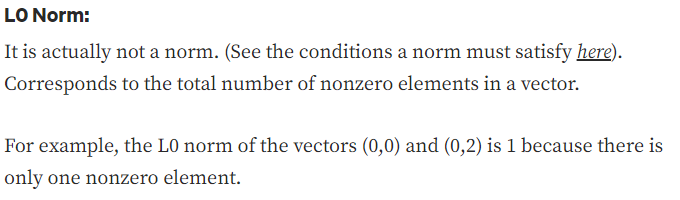

### Code

In [27]:
def final_form(X, y, Mu, Ml, Mu_ksi, Ml_ksi, k, time_limit = None):
    # Getting the number of columns
    p = X.shape[1]
    # Creating one model instance, with a name
    m = Model(name='basic_form')
    # time limit
    if (time_limit != None):
        m.set_time_limit(time_limit)
    # Setting the k binary variables called Beta
    beta = m.continuous_var_list(p, name  = 'beta')
    # Constraint 1 withworkaround
    binary_beta = m.binary_var_list(p, name = 'binary_beta') # Can't do a 0-norm, so we have to make a workaound by creating new binary variables
    for i in range(p):
        m.add_if_then(binary_beta[i] == 0, beta[i] == 0) # Then we use and if-then statement that makes Beta a 0, when binary beta is 0
    ksi = X @ beta
    const1  = m.add_constraint(sum(binary_beta)   <= k, 'const1') # Finally we let only k binary betas to be non-zero
    # Setting other constraints
    const2  = m.add_constraint(inf_pnorm(beta, m) <= Mu, 'const2')
    const3  = m.add_constraint(pnorm(beta, 1, m)  <= Ml, 'const3')
    const4  = m.add_constraint(inf_pnorm(ksi, m)  <= Mu_ksi, 'const4')
    const5  = m.add_constraint(pnorm(ksi, 1, m)   <= Ml_ksi, 'const5')

    m.minimize(norm2_2((y - X @ beta))/2)
    m.solve()
    return(m)

### Examples

In [28]:
final_df3 = final_form(X=df3, y=y3, Mu=10, Ml = 10, Mu_ksi=10, Ml_ksi = 10, k = 5)
final_df3.print_solution()
final_df3.print_information()
final_df3.export_as_lp()

objective: 479895.539
status: OPTIMAL_SOLUTION(2)
  beta_0=0.032
  beta_1=0.130
  beta_2=0.075
  beta_3=0.065
  beta_4=0.069
  binary_beta_0=1
  binary_beta_1=1
  binary_beta_2=1
  binary_beta_3=1
  binary_beta_4=1
Model: basic_form
 - number of variables: 1022
   - binary=270, integer=0, continuous=752
 - number of constraints: 927
   - linear=657, indicator=270
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP


'C:\\Users\\Hubert\\AppData\\Local\\Temp\\basic_form.lp'

In [29]:
k = 0.01
ex2_df = final_form(X=x_ex2, y=y_ex2, Mu=k, Ml = 0.1, Mu_ksi=k, Ml_ksi = k, k = 5, time_limit = 15)
ex2_df.print_solution()
ex2_df.print_information()
ex2_df.export_as_lp()

objective: 2.827
status: FEASIBLE_SOLUTION(1)
  beta_1=0.002
  beta_2=0.002
  beta_3=0.002
  beta_46=0.001
  beta_63=0.001
  binary_beta_1=1
  binary_beta_2=1
  binary_beta_3=1
  binary_beta_46=1
  binary_beta_63=1
Model: basic_form
 - number of variables: 782
   - binary=230, integer=0, continuous=552
 - number of constraints: 687
   - linear=457, indicator=230
 - parameters:
     parameters.timelimit = 15.00000000000000
 - objective: minimize quadratic
 - problem type is: MIQP


'C:\\Users\\Hubert\\AppData\\Local\\Temp\\basic_form.lp'

In [30]:
#k = 0.01
#ex2_df = final_form(X=x_ex2, y=y_ex2, Mu=k, Ml = 0.1, Mu_ksi=k, Ml_ksi = k, k = 5)
#ex2_df.print_solution()
#ex2_df.print_information()
#ex2_df.export_as_lp()

In some cases like this (when ML > ML_ksi, Mu_ksi) the method gets computationally expensive and cannot converge for hours. Because of that we introduced a timeout parameter

# Getting the Upper Bound

In [106]:
def get_UB(X, y, k):
  model = sos_1_form(X, y, k)
  betas = []
  for v in model.iter_continuous_vars():
    betas.append(v.solution_value)
  y_pred = y - (X @ betas)
  return linalg.norm(y_pred, 2)

In [107]:
print("For Example 2 Dataset")
print(f"UB = {get_UB(x_ex2, y_ex2, 5)}")

For Example 2 Dataset
UB = 0.1571440729184671


# Warmstarts

In [108]:
def g(b):
    return norm2_2(b)/2

def grad_g(X,y, b):
    return -X.transpose() @ (y - X @ b)

def lambda_max(X):
    w,v = eig(X.transpose() @ X)
    for war in w:
        print(type(war))
    return max(w)

def hkc(c_org, k, p):
    c = c_org.copy()
    c_org = np.array(c_org)
    c = [abs(item) for item in c]
    ind = np.argpartition(c, -k)[-k:]
    topk = c_org[ind].tolist()
    beta= np.array([0]*p)
    beta[ind] = topk
    return beta.tolist()


In [109]:
def warmstart(L, eps, k, X, y):
    p = X.shape[1]
    #b1
    b = list(random.sample(range(-20, 20), k)) + [0]*(p-k)
    #first step
    c = b - (1/L)*grad_g(X, y, b)
    b_next = hkc(c, k, p)

    while abs(g(b) - g(b_next)) > eps:
        b = b_next
        c = b - (1/L)*grad_g(X, y, b)
        b_next = hkc(c, k, p)

    return b_next

In [110]:
print("For Example 2 Dataset")
print(warmstart(1000, 10, 5, x_ex2, y_ex2))

For Example 2 Dataset
[0, 0, -2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [111]:
print("For Example 3 Dataset")
print(warmstart(1000, 10, 10, x_ex3, y_ex3))

For Example 3 Dataset
[0, 0, 0, 2, 0, 0, 0, 0, -4, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [112]:
print("For Example 4 Dataset")
print(warmstart(1000, 10, 6, x_ex4, y_ex4))

For Example 4 Dataset
[0, -5, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Experiments functions

## Advanced experiments

### Experiment grid

In [31]:
def experiment_grid(method, X, y, k, Mu = None, Ml = None, Mu_ksi = None, Ml_ksi = None, debug = False, time_limit = 60):
    start           = time.time()
    parameters      = []
    objectives      = []
    hyperparameters = []
    times           = []
    if (method == 'Z1'):
        if Mu == None:
            print('Mu parameter vector is needed.')
            return None
        for i in range(len(Mu)):
            s = time.time()
            sol = basic_form(X, y, Mu[i], k)
            parameters.append(sol.solution.as_df())
            objectives.append(round(sol.solution.get_objective_value(), 6))
            hyperparameters.append(Mu[i])
            e = time.time()
            times.append(round(e-s, 3))

            if (debug):
                print('Z1 method with params:', Mu[i], 'lasted', round(e-s, 3))
    
    elif (method == 'Z2'):
        if Mu == None:
            print('Mu parameter vector is needed.')
            return None
        for i in range(len(Mu)):
            s = time.time()
            sol = form_z2(X, y, Mu[i], k)
            parameters.append(sol.solution.as_df())
            objectives.append(round(sol.solution.get_objective_value(), 6))
            hyperparameters.append(Mu[i])
            e = time.time()
            times.append(round(e-s, 3))

            if (debug):
                print('Z2 method with params:', Mu[i], 'lasted', round(e-s, 3))

    elif (method == 'Z3'):
        if Mu == None:
            print('Mu parameter vector is needed.')
            return None
        for i in range(len(Mu)):
            s = time.time()
            sol = form_z3(X, y, Mu[i], k)
            parameters.append(sol.solution.as_df())
            objectives.append(round(sol.solution.get_objective_value(), 6))
            hyperparameters.append(Mu[i])
            e = time.time()
            times.append(round(e-s, 3))

            if (debug):
                print('Z3 method with params:', Mu[i], 'lasted', round(e-s, 3))

    elif (method == 'SOS1'):
        s = time.time()
        sol = sos_1_form(X, y, k)
        parameters.append(sol.solution.as_df())
        objectives.append(round(sol.solution.get_objective_value(), 6))
        hyperparameters.append(None)
        e = time.time()
        times.append(round(e-s, 3))

        if (debug):
            print('SOS1 method lasted', round(e-s, 3))

    elif (method == 'SOS2'):
        if (Mu == None) or (Ml == None):
            print('Mu and Ml parameters vectors are needed.')
            return None
        for i in range(len(Mu)):
            for j in range(len(Ml)):
                s = time.time()
                sol = sos_2_form(X, y, Mu[i], Ml[j], k, time_limit = time_limit)
                parameters.append(sol.solution.as_df())
                objectives.append(round(sol.solution.get_objective_value(), 6))
                hyperparameters.append((Mu[i], Ml[j]))
                e = time.time()
                times.append(round(e-s, 3))
                if (debug):
                    print('SOS2 method with params:', Mu[i], Ml[j], 'lasted', round(e-s, 3))

    elif (method == 'SOS3'):
        if (Mu == None) or (Ml == None) or (Mu_ksi == None) or (Ml_ksi == None):
            print('Mu, Ml, Mu_ksi, and Ml_ksi parameters vectors are needed.')
            return None
        for i in range(len(Mu)):
            for j in range(len(Ml)):
                for m in range(len(Mu_ksi)):
                    for n in range(len(Ml_ksi)):
                        s = time.time()
                        sol = sos_3_form(X, y, Mu[i], Ml[j], Mu_ksi[m], Ml_ksi[n], k, time_limit = time_limit)
                        parameters.append(sol.solution.as_df())
                        objectives.append(round(sol.solution.get_objective_value(), 6))
                        hyperparameters.append((Mu[i], Ml[j], Mu_ksi[m], Ml_ksi[n]))
                        e = time.time()
                        times.append(round(e-s, 3))
                        if (debug):
                                print('SOS3 method with params:', Mu[i], Ml[j], Mu_ksi[m], Ml_ksi[n], 'lasted', round(e-s, 3))

    elif (method == 'Final'):
        if (Mu == None) or (Ml == None) or (Mu_ksi == None) or (Ml_ksi == None):
            print('Mu, Ml, Mu_ksi, and Ml_ksi parameters vectors are needed.')
            return None
        for i in range(len(Mu)):
            for j in range(len(Ml)):
                for m in range(len(Mu_ksi)):
                    for n in range(len(Ml_ksi)):
                        s = time.time()
                        sol = final_form(X, y, Mu[i], Ml[j], Mu_ksi[m], Ml_ksi[n], k, time_limit = time_limit)
                        parameters.append(sol.solution.as_df())
                        objectives.append(round(sol.solution.get_objective_value(), 6))
                        hyperparameters.append((Mu[i], Ml[j], Mu_ksi[m], Ml_ksi[n]))
                        e = time.time()
                        times.append(round(e-s, 3))
                        if (debug):
                            print('Final method with params:', Mu[i], Ml[j], Mu_ksi[m], Ml_ksi[n], 'lasted', round(e-s, 3))
    end = time.time()
    print('Method', method, 'training lasted:', end - start, 'seconds.')
    names = np.repeat(method, len(objectives), axis=0)

    return (parameters, objectives, hyperparameters, names, times)

In [32]:
exp3 = experiment_grid(method = 'SOS2', X=x_ex2, y=y_ex2, Mu = [0.01, 0.1, 1, 10], Ml = [0.01, 0.1, 1, 10], k = 5, debug = True)

SOS2 method with params: 0.01 0.01 lasted 0.118
SOS2 method with params: 0.01 0.1 lasted 0.136
SOS2 method with params: 0.01 1 lasted 0.191
SOS2 method with params: 0.01 10 lasted 0.113
SOS2 method with params: 0.1 0.01 lasted 0.118
SOS2 method with params: 0.1 0.1 lasted 0.124
SOS2 method with params: 0.1 1 lasted 0.13
SOS2 method with params: 0.1 10 lasted 0.13
SOS2 method with params: 1 0.01 lasted 0.116
SOS2 method with params: 1 0.1 lasted 0.123
SOS2 method with params: 1 1 lasted 0.216
SOS2 method with params: 1 10 lasted 0.151
SOS2 method with params: 10 0.01 lasted 0.117
SOS2 method with params: 10 0.1 lasted 0.122
SOS2 method with params: 10 1 lasted 0.143
SOS2 method with params: 10 10 lasted 0.404
Method SOS2 training lasted: 2.4532663822174072 seconds.


In [65]:
# It works but takes a long time to finish
#exp4 = experiment_grid(method = 'Final', X=x_ex2, y=y_ex2, Mu = [0.01, 0.1], Ml = [0.01, 0.1], Mu_ksi = [0.01, 0.1], Ml_ksi = [0.01, 0.1], k = 5, debug = True, time_limit = 60)

Final method with params: 0.01 0.01 0.01 0.01 lasted 15.644
Final method with params: 0.01 0.01 0.01 0.1 lasted 0.715
Final method with params: 0.01 0.01 0.1 0.01 lasted 16.542
Final method with params: 0.01 0.01 0.1 0.1 lasted 0.729
Final method with params: 0.01 0.1 0.01 0.01 lasted 60.604
Final method with params: 0.01 0.1 0.01 0.1 lasted 1.407
Final method with params: 0.01 0.1 0.1 0.01 lasted 60.648
Final method with params: 0.01 0.1 0.1 0.1 lasted 1.427
Final method with params: 0.1 0.01 0.01 0.01 lasted 19.002
Final method with params: 0.1 0.01 0.01 0.1 lasted 0.714
Final method with params: 0.1 0.01 0.1 0.01 lasted 10.514
Final method with params: 0.1 0.01 0.1 0.1 lasted 0.654
Final method with params: 0.1 0.1 0.01 0.01 lasted 60.587
Final method with params: 0.1 0.1 0.01 0.1 lasted 31.61
Final method with params: 0.1 0.1 0.1 0.01 lasted 60.694
Final method with params: 0.1 0.1 0.1 0.1 lasted 7.499
Method Final training lasted: 348.986962556839 seconds.


### Balanced accuracy

**Balanced Accuracy** is used in both binary and multi-class classification. It’s the arithmetic mean of sensitivity and specificity, its use case is when dealing with imbalanced data, i.e. when one of the target classes appears a lot more than the other, which is the case for the Feature selection Task

**Sensitivity:** This is also known as true positive rate or recall, it measures the proportion of real positives that are correctly predicted out of all positive predictions that could be made by the model. *Sensitivity= TP / (TP + FN)*

**Specificity:** Also known as true negative rate, it measures the proportion of correctly identified negatives over the total negative predictions that could be made by the model. *Specificity =TN / (TN + FP)*

In [32]:
def balanced_accuracy(exp, X, k, time_limit = None):
    Ba_b          = []
    Sensitivity_b = []
    Specificity_b = []
    Ba_z          = []
    Sensitivity_z = []
    Specificity_z = []

    Zs = False

    for i in range(len(exp[0])):
        preds   = [exp[0][i]['name'][j] for j in range(len(exp[0][i]['name']))]

        b_idx   = [True if preds[j][0:4] == 'beta' else False for j in range(len(preds))]
        preds_b = list(compress(preds, b_idx))
        tp_b = sum([1 if int(preds_b[j][5:]) <= k else 0 for j in range(len(preds_b))])
        fp_b = sum([1 if int(preds_b[j][5:]) > k else 0 for j in range(len(preds_b))])
        tn_b = X.shape[1] - k - fp_b
        fn_b = k - tp_b
        #print((tp_b, fp_b, tn_b, fn_b))
        sensitivity_b = tp_b / (tp_b + fn_b)
        specificity_b = tn_b / (tn_b + fp_b)
        ba_b = (sensitivity_b + specificity_b) / 2
        Sensitivity_b.append(round(sensitivity_b, 3))
        Specificity_b.append(round(specificity_b, 3))
        Ba_b.append(round(ba_b, 3))

        z_idx   = [True if preds[j][0:2] == 'z_' else False for j in range(len(preds))]
        if sum(z_idx) != 0:
            Zs = True
            preds_z = list(compress(preds, z_idx))
            tp_z = sum([1 if int(preds_z[j][2:]) <= k else 0 for j in range(len(preds_z))])
            fp_z = sum([1 if int(preds_z[j][2:]) > k else 0 for j in range(len(preds_z))])
            tn_z = X.shape[1] - k - fp_z
            fn_z = k - tp_z
            sensitivity_z = tp_z / (tp_z + fn_z)
            specificity_z = tn_z / (tn_z + fp_z)
            ba_z = (sensitivity_z + specificity_z) / 2
            Sensitivity_z.append(round(sensitivity_z, 3))
            Specificity_z.append(round(specificity_z, 3))
            Ba_z.append(round(ba_z, 3))

    names = np.repeat(exp[3][0], len(Sensitivity_b))

    timeout = []
    if (time_limit != None):
        for i in range(len(exp[4])):
            if (exp[4][i] >= time_limit):
                timeout.append('Yes')
            else:
                timeout.append('No')
        timeout_name = 'Timeout at ' + str(time_limit)
    else:
        timeout_name = str('Timeout')
        timeout = np.repeat('No', len(exp[4]))
    
    if Zs:
        #print(len(Ba_b), len(Sensitivity_b), len(Specificity_b), len(names), len(np.repeat('beta', len(Sensitivity_b))), len(exp[2]), len(exp[1]), len(exp[4]), len(timeout))
        b_df = pd.DataFrame({'BalancedAccuracy': Ba_b, 'Sensitivity': Sensitivity_b, 'Specificity': Specificity_b, 'Method': names, 'Type': np.repeat('beta', len(Sensitivity_b)), 
                             'Hyperparameters': exp[2], 'Objective Value': exp[1], 'Time(s)': exp[4], timeout_name: timeout})
        #print(len(Ba_b), len(Sensitivity_z), len(Specificity_z), len(names), len(np.repeat('z', len(Sensitivity_b))), len(exp[2]), len(exp[1]), len(exp[4]), len(timeout))    
        z_df = pd.DataFrame({'BalancedAccuracy': Ba_z, 'Sensitivity': Sensitivity_z, 'Specificity': Specificity_z, 'Method': names, 'Type': np.repeat('z', len(Sensitivity_b)), 
                             'Hyperparameters': exp[2], 'Objective Value': exp[1], 'Time(s)': exp[4], timeout_name: timeout})  
        return pd.concat([b_df, z_df], ignore_index=True)
    else:
        b_df = pd.DataFrame({'BalancedAccuracy': Ba_b, 'Sensitivity': Sensitivity_b, 'Specificity': Specificity_b, 'Method': names, 'Type': np.repeat('beta', len(Sensitivity_b)), 
                             'Hyperparameters': exp[2], 'Objective Value': exp[1], 'Time(s)': exp[4], timeout_name: timeout})   
        return b_df

In [34]:
exp = experiment_grid(method = 'Z1', X=x_ex2, y=y_ex2, Mu = [0.1, 1, 10], k = 5)
df1 = balanced_accuracy(exp, x_ex2, 5)
df1

Method Z1 training lasted: 5.455860376358032 seconds.


BalancedAccuracy  Sensitivity  Specificity Method  Type  Hyperparameters   
0             0.895          0.8        0.989     Z1  beta              0.1  \
1             1.000          1.0        1.000     Z1  beta              1.0   
2             1.000          1.0        1.000     Z1  beta             10.0   
3             0.895          0.8        0.989     Z1     z              0.1   
4             1.000          1.0        1.000     Z1     z              1.0   
5             1.000          1.0        1.000     Z1     z             10.0   

   Objective Value  Time(s) Timeout  
0         2.272136    0.652      No  
1         0.012481    0.577      No  
2         0.012347    4.227      No  
3         2.272136    0.652      No  
4         0.012481    0.577      No  
5         0.012347    4.227      No

### Multiple experiments

In [33]:
def multiple_exp(methods, X, y, k, Mu = None, Ml = None, Mu_ksi = None, Ml_ksi = None, time_limit= 60):
    exp = []
    results = pd.DataFrame()
    for i in range(len(methods)):
        print('Current method is:', methods[i])
        exp.append(experiment_grid(method = methods[i], X=X, y=y, k = 5, Mu = Mu, Ml = Ml, Mu_ksi = Mu_ksi, Ml_ksi = Ml_ksi, time_limit=time_limit))
    results = balanced_accuracy(exp[0], X, k, time_limit = time_limit)
    for i in range(1, len(exp)):
        results = pd.concat([results, balanced_accuracy(exp[i], X, k)], ignore_index=True)

    return(results)

In [45]:
#toy_results = multiple_exp(methods = ['Z1', 'Z2', 'Z3', 'SOS1', 'SOS2', 'SOS3', 'Final'], X=x_ex2, y=y_ex2, k=5, Mu = [0.01, 0.1], Ml = [0.01, 0.1,], Mu_ksi = [0.01, 0.1], Ml_ksi = [0.01, 0.1], time_limit = 60)
#toy_results.to_pickle('toy_results.pkl')
toy_results = pd.read_pickle('toy_results.pkl')

In [36]:
# Enormously long exectuion for Final method. Apparently some params combinations cpnsume resources badly.
#results2 = multiple_exp(methods = ['Z1', 'Z2', 'Z3', 'SOS1', 'SOS2', 'SOS3', 'Final'], X=x_ex2, y=y_ex2, k=5, Mu = [0.01, 0.1, 1, 10], Ml = [0.01, 0.1, 1, 10], Mu_ksi = [0.01, 0.1, 1, 10], Ml_ksi = [0.01, 0.1, 1, 10])
#results2.to_pickle('outcomes_ex_2.pkl')

Current method is: Z1
Method Z1 training lasted: 6.07222580909729 seconds.
Current method is: Z2
Method Z2 training lasted: 2.282923460006714 seconds.
Current method is: Z3
Method Z3 training lasted: 2.2706642150878906 seconds.
Current method is: SOS1
Method SOS1 training lasted: 19.62152075767517 seconds.
Current method is: SOS2
Method SOS2 training lasted: 2.3823494911193848 seconds.
Current method is: SOS3
Method SOS3 training lasted: 7585.46116733551 seconds.
Current method is: Final


## SOS 3 and Final methods helper functions

In [46]:
def return_best_set(df):
    best_sos3  = (-1, -1, -1, -1)
    best_final = (-1, -1, -1, -1)

    sos3_df  = df[(df['Method'] == 'SOS3') & (df['Type'] == 'beta')].reset_index(drop = True)
    final_df = df[df['Method'] == 'Final'].reset_index(drop = True)

    best = (0, np.inf)
    for i in range(len(sos3_df)):
        if (sos3_df['BalancedAccuracy'][i] > best[0]):
            best = sos3_df['BalancedAccuracy'][i], sos3_df['Objective Value'][i]
            best_sos3 = sos3_df['Hyperparameters'][i]
        elif ((sos3_df['BalancedAccuracy'][i] == best[0]) & (sos3_df['Objective Value'][i] < best[1])):
            best = sos3_df['BalancedAccuracy'][i], sos3_df['Objective Value'][i]
            best_sos3 = sos3_df['Hyperparameters'][i]
    
    best = (0, np.inf)
    for i in range(len(final_df)):
        if (final_df['BalancedAccuracy'][i] > best[0]):
            best = final_df['BalancedAccuracy'][i], final_df['Objective Value'][i]
            best_final = final_df['Hyperparameters'][i]
        elif ((final_df['BalancedAccuracy'][i] == best[0]) & (final_df['Objective Value'][i] < best[1])):
            best = final_df['BalancedAccuracy'][i], final_df['Objective Value'][i]
            best_final = final_df['Hyperparameters'][i]

    return best_sos3, best_final


toy_best_results = return_best_set(toy_results)
toy_best_results

((0.01, 0.1, 0.1, 0.1), (0.01, 0.1, 0.1, 0.1))

In [87]:
def conduct_parameter_study(X, y, k, best_results, method, time_limit = 60):
    start           = time.time()
    parameters      = []
    objectives      = []
    hyperparameters = []
    times           = []
    if method == 'SOS3':
        for param in [0.01, 0.05, 0.1, 0.5, 1, 5, 10]:
            s = time.time()
            sol = sos_3_form(X, y, param, best_results[0][1], best_results[0][2], best_results[0][3], k, time_limit = time_limit)
            parameters.append(sol.solution.as_df())
            objectives.append(round(sol.solution.get_objective_value(), 6))
            hyperparameters.append((param, best_results[0][1], best_results[0][2], best_results[0][3]))
            e = time.time()
            times.append(round(e-s, 3))

            s = time.time()
            sol = sos_3_form(X, y, best_results[0][0], param, best_results[0][2], best_results[0][3], k, time_limit = time_limit)
            parameters.append(sol.solution.as_df())
            objectives.append(round(sol.solution.get_objective_value(), 6))
            hyperparameters.append((best_results[0][0], param, best_results[0][2], best_results[0][3]))
            e = time.time()
            times.append(round(e-s, 3))

            s = time.time()
            sol = sos_3_form(X, y, best_results[0][0], best_results[0][1], param, best_results[0][3], k, time_limit = time_limit)
            parameters.append(sol.solution.as_df())
            objectives.append(round(sol.solution.get_objective_value(), 6))
            hyperparameters.append((best_results[0][0], best_results[0][1], param, best_results[0][3]))
            e = time.time()
            times.append(round(e-s, 3))

            s = time.time()
            sol = sos_3_form(X, y, best_results[0][0], best_results[0][1], best_results[0][2], param, k, time_limit = time_limit)
            parameters.append(sol.solution.as_df())
            objectives.append(round(sol.solution.get_objective_value(), 6))
            hyperparameters.append((best_results[0][0], best_results[0][1], best_results[0][2], param))
            e = time.time()
            times.append(round(e-s, 3))
        names = np.repeat('SOS3', len(objectives), axis=0)

    if method == 'Final':
        for param in [0.01, 0.05, 0.1, 0.5, 1, 5, 10]:
            s = time.time()
            sol = final_form(X, y, param, best_results[1][1], best_results[1][2], best_results[1][3], k, time_limit = time_limit)
            parameters.append(sol.solution.as_df())
            objectives.append(round(sol.solution.get_objective_value(), 6))
            hyperparameters.append((param, best_results[1][1], best_results[1][2], best_results[1][3]))
            e = time.time()
            times.append(round(e-s, 3))

            s = time.time()
            sol = final_form(X, y, best_results[1][0], param, best_results[1][2], best_results[1][3], k, time_limit = time_limit)
            parameters.append(sol.solution.as_df())
            objectives.append(round(sol.solution.get_objective_value(), 6))
            hyperparameters.append((best_results[1][0], param, best_results[1][2], best_results[1][3]))
            e = time.time()
            times.append(round(e-s, 3))

            s = time.time()
            sol = final_form(X, y, best_results[1][0], best_results[1][1], param, best_results[1][3], k, time_limit = time_limit)
            parameters.append(sol.solution.as_df())
            objectives.append(round(sol.solution.get_objective_value(), 6))
            hyperparameters.append((best_results[1][0], best_results[1][1], param, best_results[1][3]))
            e = time.time()
            times.append(round(e-s, 3))

            s = time.time()
            sol = final_form(X, y, best_results[1][0], best_results[1][1], best_results[1][2], param, k, time_limit = time_limit)
            parameters.append(sol.solution.as_df())
            objectives.append(round(sol.solution.get_objective_value(), 6))
            hyperparameters.append((best_results[1][0], best_results[1][1], best_results[1][2], param))
            e = time.time()
            times.append(round(e-s, 3))
        names = np.repeat('Final', len(objectives), axis=0)

    return (parameters, objectives, hyperparameters, names, times)

In [ ]:
sos3_parameter_study = conduct_parameter_study(X = x_ex2, y = y_ex2, k = 5, best_results = toy_best_results, method = 'SOS3', time_limit = 2)
sos3_study = balanced_accuracy(sos3_parameter_study, x_ex2, 5, time_limit = 2)
final_parameter_study = conduct_parameter_study(X = x_ex2, y = y_ex2, k = 5, best_results = toy_best_results, method = 'Final', time_limit = 2)
final_study = balanced_accuracy(final_parameter_study, x_ex2, 5, time_limit = 2)

### Plots

#### Heatmap

In [40]:
toy_results = pd.read_pickle('toy_results.pkl')

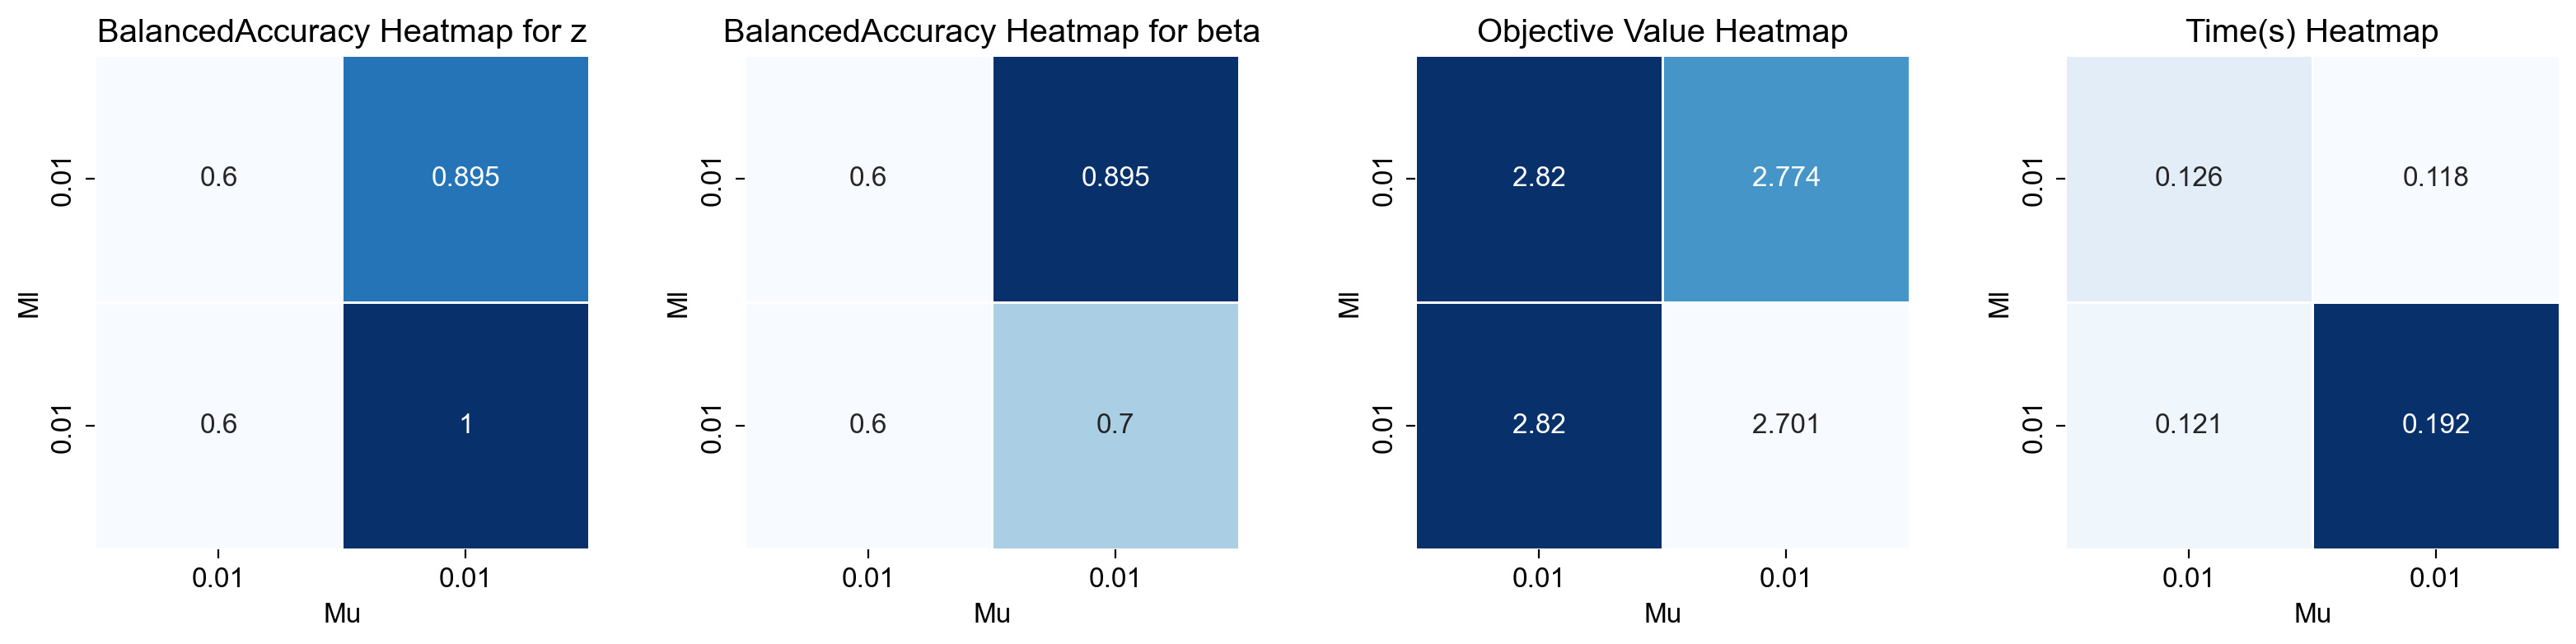

In [48]:
def plot_heatmap(df, typ, metric):
    method = 'SOS2'
    sqt   = int(math.sqrt(len(df[(df['Method'] == method) & (df['Type'] == typ)])))
    mt    = df[(df['Method'] == method) & (df['Type'] == typ)][metric].values.reshape(sqt, sqt)
    index = [df[(df['Method'] == method) & (df['Type'] == typ)]['Hyperparameters'].reset_index(drop = True)[i][int((sqt**(1/2))/2)] for i in range(sqt)]
    mt    = pd.DataFrame(mt, columns = index, index = index)

    #plt.figure(figsize=(8, 7))
    label = str(str(typ) + str(metric))
    ax1 = pw.Brick(label, figsize=(3, 3))

    #sns.heatmap(mt, annot=True, linewidth=.5, ax = ax1, cbar_ax = ax1)
    sns.heatmap(mt, annot=True, linewidth=.5, ax = ax1, fmt='.4g', cmap='Blues')
    if metric == 'BalancedAccuracy':
        ax1.set_title(str(metric) + ' Heatmap for ' + str(typ))
    else:
        ax1.set_title(str(metric) + ' Heatmap')
    ax1.set_xlabel("Mu")
    ax1.set_ylabel("Ml")
    #ax1.savefig()
    return ax1

def plot_sos2_experiment(df):
    pw.clear()
    pw.Brick._labelset.clear()
    p1 = plot_heatmap(df, 'z', 'BalancedAccuracy')
    p2 = plot_heatmap(df, 'beta', 'BalancedAccuracy')
    p3 = plot_heatmap(df, 'beta', 'Objective Value')
    p4 = plot_heatmap(df, 'beta', 'Time(s)')

    return ((p1 | p2) | (p3 | p4))

plot_sos2_experiment(toy_results)


In [42]:
pd.set_option('display.max_rows', None)
toy_results

BalancedAccuracy  Sensitivity  Specificity Method  Type   
0              0.895          0.8        0.989     Z1  beta  \
1              0.895          0.8        0.989     Z1  beta   
2              0.895          0.8        0.989     Z1     z   
3              0.895          0.8        0.989     Z1     z   
4              0.895          0.8        0.989     Z2  beta   
5              0.889          0.8        0.979     Z2  beta   
6              0.600          0.2        1.000     Z3  beta   
7              0.800          0.6        1.000     Z3  beta   
8              1.000          1.0        1.000   SOS1  beta   
9              1.000          1.0        1.000   SOS1     z   
10             0.600          0.2        1.000   SOS2  beta   
11             0.895          0.8        0.989   SOS2  beta   
12             0.600          0.2        1.000   SOS2  beta   
13             0.700          0.4        1.000   SOS2  beta   
14             0.600          0.2        1.000   SOS2     z   
15             0.895          0.8        0.989   SOS2     z   
16             0.600          0.2        1.000   SOS2     z   
17             1.000          1.0        1.000   SOS2     z   
18             0.895          0.8        0.989   SOS3  beta   
19             0.700          0.4        1.000   SOS3  beta   
20             0.895          0.8        0.989   SOS3  beta   
21             0.700          0.4        1.000   SOS3  beta   
22             0.895          0.8        0.989   SOS3  beta   
23             0.895          0.8        0.989   SOS3  beta   
24             0.895          0.8        0.989   SOS3  beta   
25             1.000          1.0        1.000   SOS3  beta   
26             0.895          0.8        0.989   SOS3  beta   
27             0.700          0.4        1.000   SOS3  beta   
28             0.895          0.8        0.989   SOS3  beta   
29             0.700          0.4        1.000   SOS3  beta   
30             0.895          0.8        0.989   SOS3  beta   
31             1.000          1.0        1.000   SOS3  beta   
32             0.895          0.8        0.989   SOS3  beta   
33             0.895          0.8        0.989   SOS3  beta   
34             0.895          0.8        0.989   SOS3     z   
35             0.700          0.4        1.000   SOS3     z   
36             0.895          0.8        0.989   SOS3     z   
37             0.700          0.4        1.000   SOS3     z   
38             0.895          0.8        0.989   SOS3     z   
39             0.895          0.8        0.989   SOS3     z   
40             0.895          0.8        0.989   SOS3     z   
41             1.000          1.0        1.000   SOS3     z   
42             0.895          0.8        0.989   SOS3     z   
43             0.700          0.4        1.000   SOS3     z   
44             0.895          0.8        0.989   SOS3     z   
45             0.700          0.4        1.000   SOS3     z   
46             0.895          0.8        0.989   SOS3     z   
47             1.000          1.0        1.000   SOS3     z   
48             0.895          0.8        0.989   SOS3     z   
49             0.895          0.8        0.989   SOS3     z   
50             0.895          0.8        0.989  Final  beta   
51             0.600          0.2        1.000  Final  beta   
52             0.895          0.8        0.989  Final  beta   
53             0.700          0.4        1.000  Final  beta   
54             0.789          0.6        0.979  Final  beta   
55             0.895          0.8        0.989  Final  beta   
56             0.895          0.8        0.989  Final  beta   
57             1.000          1.0        1.000  Final  beta   
58             0.895          0.8        0.989  Final  beta   
59             0.600          0.2        1.000  Final  beta   
60             0.895          0.8        0.989  Final  beta   
61             0.600          0.2        1.000  Final  beta   
62             0.895          0.8  

#### Line plot for Z1, Z2, Z3

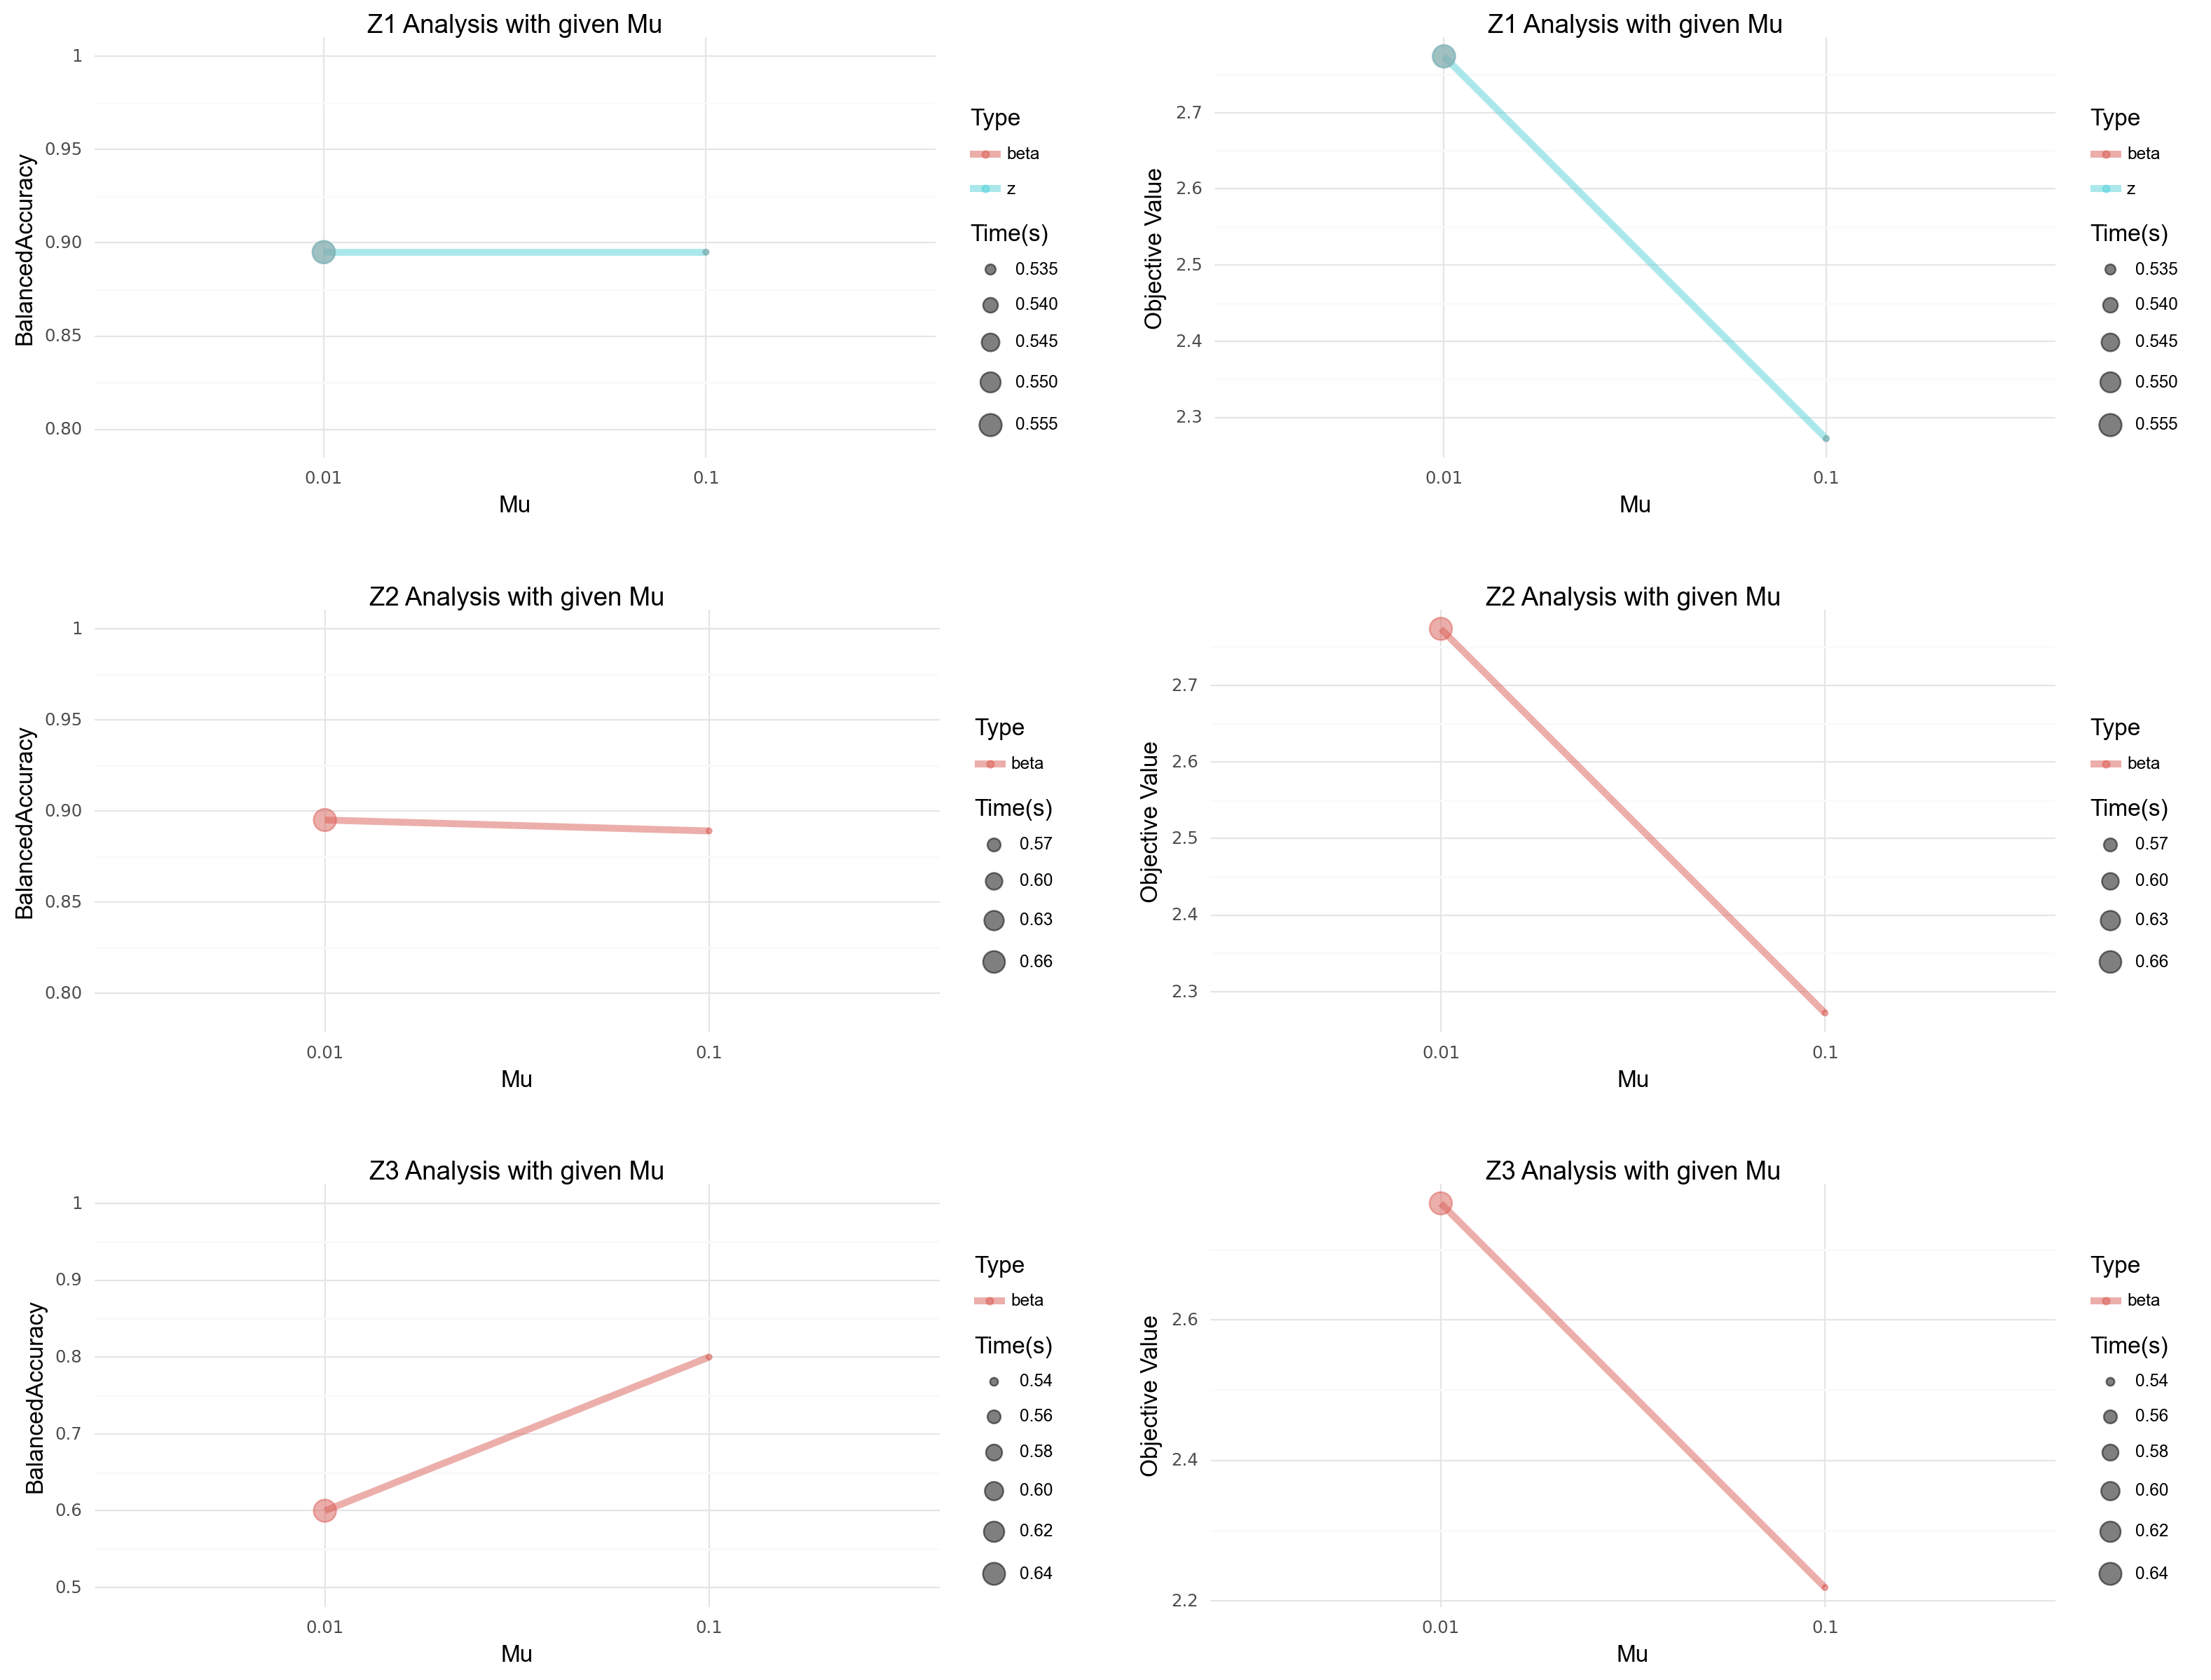

In [69]:
def plot_line(df, method, metric):
    mt =  df[(df['Method'] == method)]
    #p9.options.figure_size = (5, 5)
    
    p = (ggplot(mt, aes(x='Hyperparameters', y=metric, group = 2, color = 'Type'))
    + geom_line(alpha = 0.5, size = 2)
    + geom_point(aes(size = 'Time(s)'), alpha = 0.5)
    + theme_minimal()
    + labs(title=str(method) + ' Analysis with given Mu', 
           x='Mu', 
           y=metric,
           color = 'Type'))

    if (metric == 'BalancedAccuracy'):
        mini = min(mt['BalancedAccuracy']) - 0.1
        p = p + ylim(mini, 1)

    return p

def plot_z_experiment(df, method):
    p1 = plot_line(df, method, 'BalancedAccuracy')
    p2 = plot_line(df, method, 'Objective Value')
    p1 = pw.load_ggplot(p1, figsize=(6, 3))
    p2 = pw.load_ggplot(p2, figsize=(6, 3))

    return (p1 | p2)

def plot_z_experiments(df):
    p1 = plot_z_experiment(df, 'Z1')
    p2 = plot_z_experiment(df, 'Z2')
    p3 = plot_z_experiment(df, 'Z3')

    return p1 / p2 / p3

plot_z_experiments(toy_results)

#### Line plot for SOS3 and Final

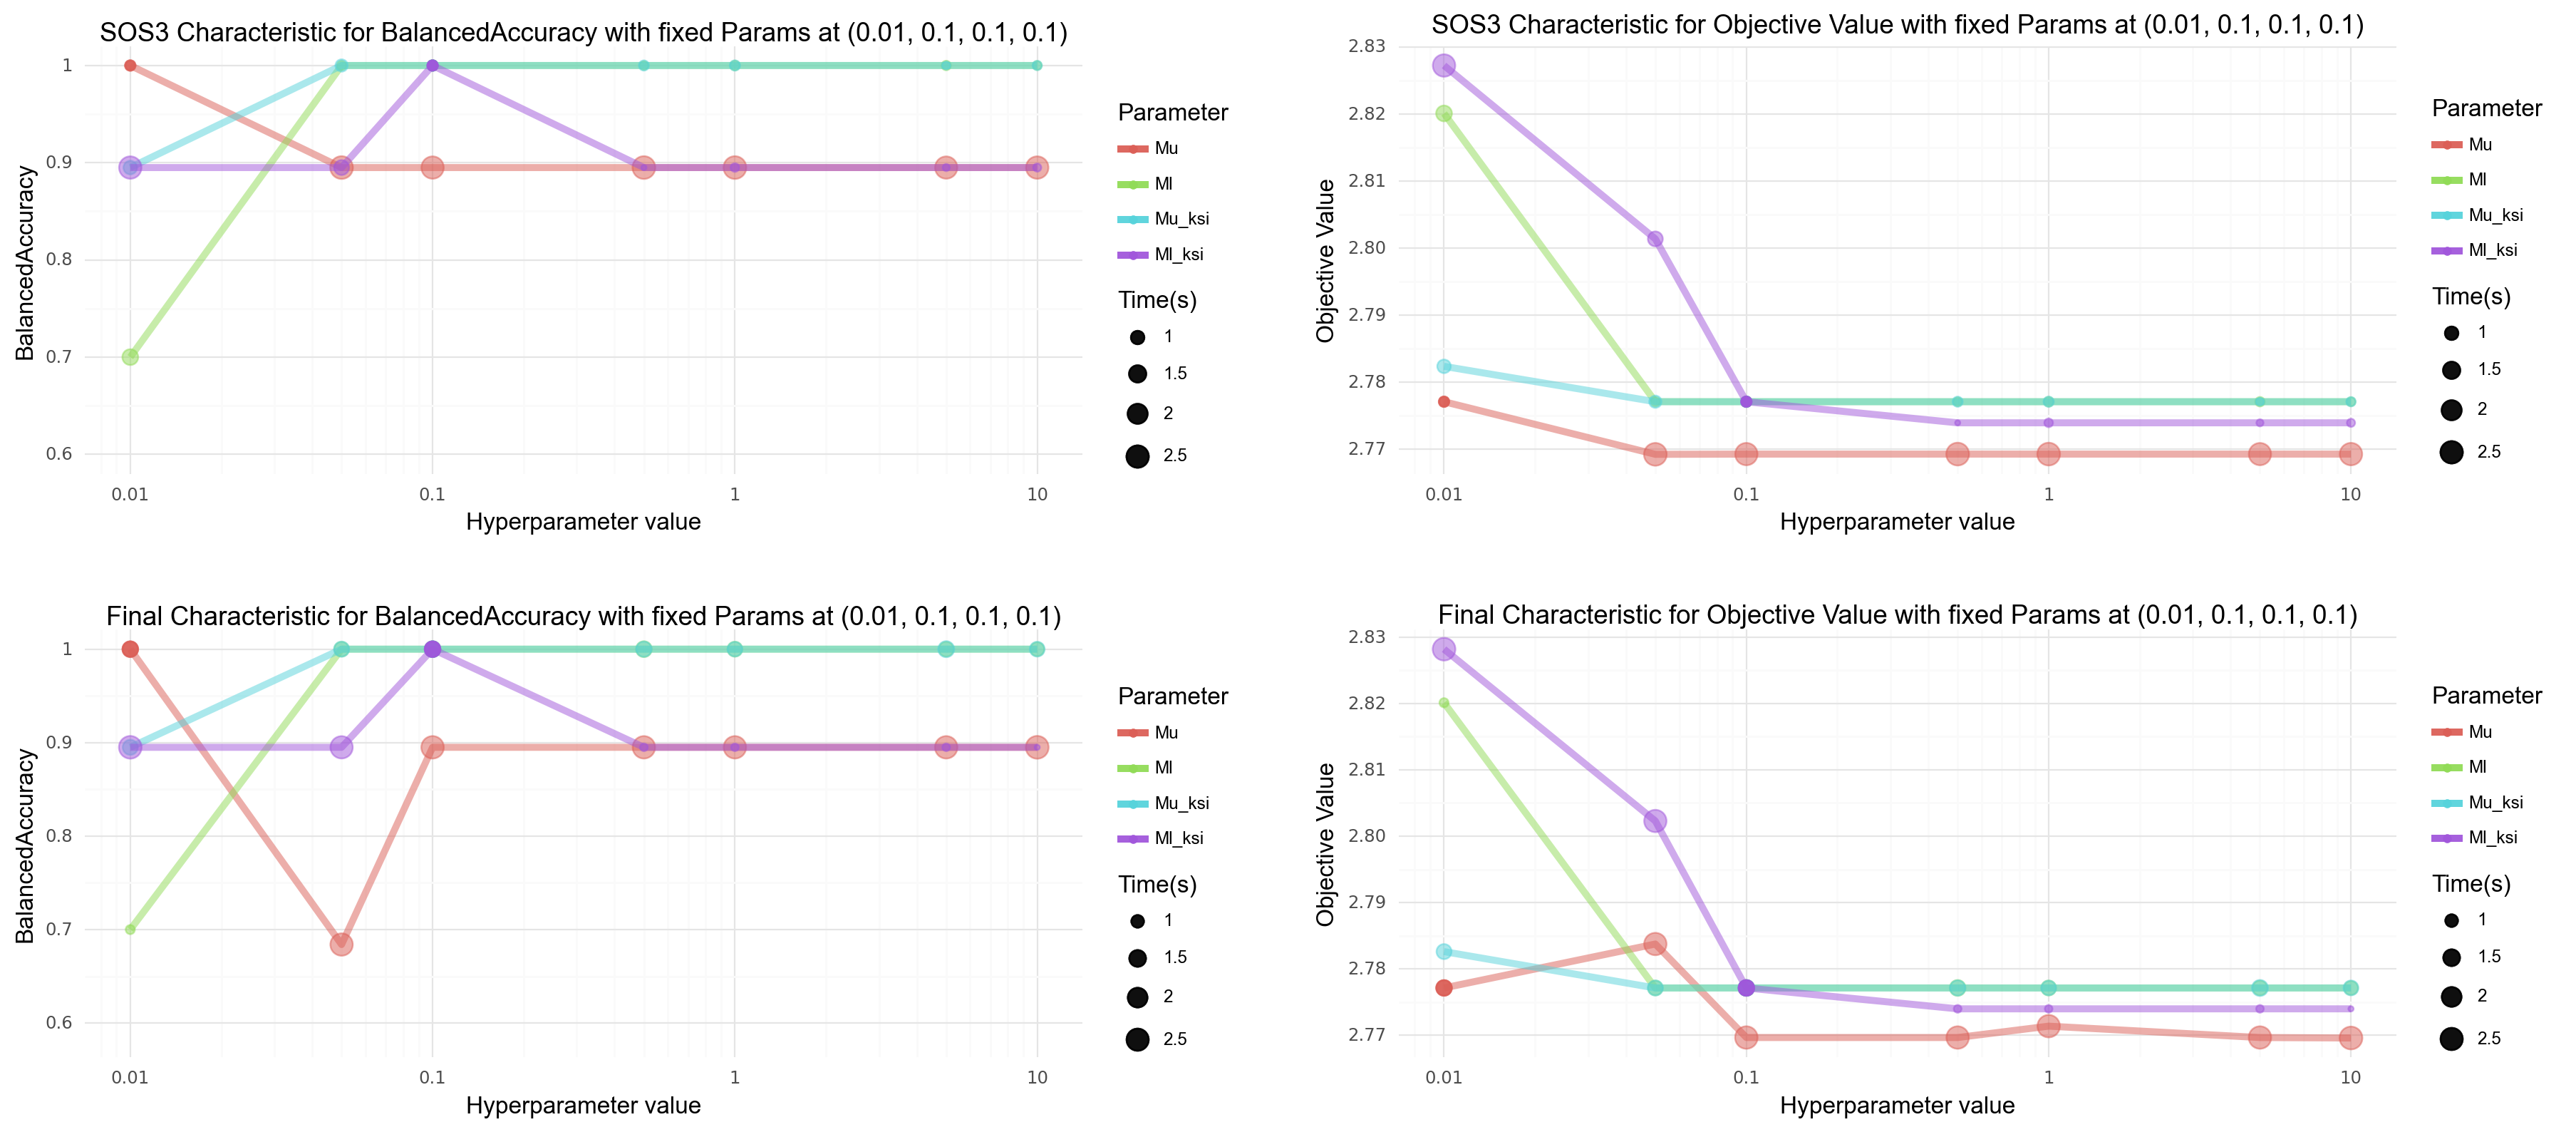

In [50]:
def plot_line_study(df, method, metric, best_results):

    if method == 'SOS3':
        best_results = best_results[0]
    else:
        best_results = best_results[1]

    mt = df[df['Type'] == 'beta']
    mt['Mu'] = [mt['Hyperparameters'][i][0] for i in range(len(mt))]
    mt['Ml'] = [mt['Hyperparameters'][i][1] for i in range(len(mt))]
    mt['Mu_ksi'] = [mt['Hyperparameters'][i][2] for i in range(len(mt))]
    mt['Ml_ksi'] = [mt['Hyperparameters'][i][3] for i in range(len(mt))]
    
    mtMu = mt[(mt['Ml'] == best_results[1]) &
          (mt['Mu_ksi'] == best_results[2]) &
          (mt['Ml_ksi'] == best_results[3])]
    
    mtMl = mt[(mt['Mu'] == best_results[0]) &
          (mt['Mu_ksi'] == best_results[2]) &
          (mt['Ml_ksi'] == best_results[3])]
    
    mtMu_ksi = mt[(mt['Mu'] == best_results[0]) &
                  (mt['Ml'] == best_results[1]) &
                  (mt['Ml_ksi'] == best_results[3])]
    
    mtMl_ksi = mt[(mt['Mu'] == best_results[0]) &
                  (mt['Ml'] == best_results[1]) &
                  (mt['Mu_ksi'] == best_results[2])]

    p = (ggplot()
    + geom_line(mtMu, aes(x='Mu', y=metric, group = 1, color = "'Mu'"), alpha = 0.5, size = 2)
    + geom_point(mtMu, aes(x='Mu', y=metric, group = 1, color = "'Mu'", size = 'Time(s)'), alpha = 0.5)
    + geom_line(mtMl, aes(x='Ml', y=metric, group = 1, color = "'Ml'"), alpha = 0.5, size = 2)
    + geom_point(mtMl, aes(x='Ml', y=metric, group = 1, color = "'Ml'", size = 'Time(s)'), alpha = 0.5)
    + geom_line(mtMu_ksi, aes(x='Mu_ksi', y=metric, group = 1, color = "'Mu_ksi'"), alpha = 0.5, size = 2)
    + geom_point(mtMu_ksi, aes(x='Mu_ksi', y=metric, group = 1, color = "'Mu_ksi'", size = 'Time(s)'), alpha = 0.5)
    + geom_line(mtMl_ksi, aes(x='Ml_ksi', y=metric, group = 1, color = "'Ml_ksi'"), alpha = 0.5, size = 2)
    + geom_point(mtMl_ksi, aes(x='Ml_ksi', y=metric, group = 1, color = "'Ml_ksi'", size = 'Time(s)'), alpha = 0.5)
    + theme_minimal()
    + scale_x_log10()
    + labs(title = str(method) + ' Characteristic for ' + str(metric) + ' with fixed Params at ' + str(best_results),
           x = 'Hyperparameter value', 
           y = metric,
           color = 'Parameter'))

    if (metric == 'BalancedAccuracy'):
        mini = min(mt['BalancedAccuracy']) - 0.1
        p = p + ylim(mini, 1)

    return p

def plot_line_study_experiment(df, method, best_results):
    p1 = plot_line_study(df, method, 'BalancedAccuracy', best_results)
    p2 = plot_line_study(df, method, 'Objective Value', best_results)
    p1 = pw.load_ggplot(p1, figsize=(7, 3))
    p2 = pw.load_ggplot(p2, figsize=(7, 3))

    return (p1 | p2)

def plot_line_study_experiments(df, df2, best_results):
    p1 = plot_line_study_experiment(df, 'SOS3', best_results)
    p2 = plot_line_study_experiment(df2, 'Final', best_results)

    return p1 / p2 

plot_line_study_experiments(sos3_study, final_study, toy_best_results)

# Experiments

## Main experiment function

In [37]:
results2 = multiple_exp(methods = ['Z1', 'Z2', 'Z3', 'SOS1', 'SOS2', 'SOS3', 'Final'], X=x_ex2, y=y_ex2, k=5, Mu = [0.01, 0.1, 1, 10], Ml = [0.01, 0.1, 1, 10], Mu_ksi = [0.01, 0.1, 1, 10], Ml_ksi = [0.01, 0.1, 1, 10], time_limit = 60)
results2.to_pickle('results2.pkl')

Current method is: Z1
Method Z1 training lasted: 6.260533809661865 seconds.
Current method is: Z2
Method Z2 training lasted: 2.3442842960357666 seconds.
Current method is: Z3
Method Z3 training lasted: 2.3594284057617188 seconds.
Current method is: SOS1
Method SOS1 training lasted: 20.671732664108276 seconds.
Current method is: SOS2
Method SOS2 training lasted: 2.76412296295166 seconds.
Current method is: SOS3
Method SOS3 training lasted: 4488.948211193085 seconds.
Current method is: Final
Method Final training lasted: 5470.705590248108 seconds.


In [38]:
results3 = multiple_exp(methods = ['Z1', 'Z2', 'Z3', 'SOS1', 'SOS2', 'SOS3', 'Final'], X=x_ex3, y=y_ex3, k=10, Mu = [0.01, 0.1, 1, 10], Ml = [0.01, 0.1, 1, 10], Mu_ksi = [0.01, 0.1, 1, 10], Ml_ksi = [0.01, 0.1, 1, 10], time_limit = 60)
results3.to_pickle('results3.pkl')

Current method is: Z1
Method Z1 training lasted: 2.503567695617676 seconds.
Current method is: Z2
Method Z2 training lasted: 2.1311519145965576 seconds.
Current method is: Z3
Method Z3 training lasted: 2.032613515853882 seconds.
Current method is: SOS1
Method SOS1 training lasted: 74.23635172843933 seconds.
Current method is: SOS2
Method SOS2 training lasted: 1.9567561149597168 seconds.
Current method is: SOS3
Method SOS3 training lasted: 4683.172255992889 seconds.
Current method is: Final
Method Final training lasted: 5100.833949804306 seconds.


In [39]:
results4 = multiple_exp(methods = ['Z1', 'Z2', 'Z3', 'SOS1', 'SOS2', 'SOS3', 'Final'], X=x_ex4, y=y_ex4, k=6, Mu = [0.01, 0.1, 1, 10], Ml = [0.01, 0.1, 1, 10], Mu_ksi = [0.01, 0.1, 1, 10], Ml_ksi = [0.01, 0.1, 1, 10], time_limit = 60)
results4.to_pickle('results4.pkl')

Current method is: Z1
Method Z1 training lasted: 3.3174619674682617 seconds.
Current method is: Z2
Method Z2 training lasted: 2.241183042526245 seconds.
Current method is: Z3
Method Z3 training lasted: 2.001882791519165 seconds.
Current method is: SOS1
Method SOS1 training lasted: 73.4156391620636 seconds.
Current method is: SOS2
Method SOS2 training lasted: 2.146481513977051 seconds.
Current method is: SOS3
Method SOS3 training lasted: 5793.6599934101105 seconds.
Current method is: Final
Method Final training lasted: 6619.599006414413 seconds.


## Further results for SOS3 and Final methods

In [42]:
extensional_results_2 = return_best_set(results2)
#extensional_results_2.to_pickle('extensional_results_2.pkl')

extensional_results_3 = return_best_set(results3)
#extensional_results_3.to_pickle('extensional_results_3.pkl')

extensional_results_4 = return_best_set(results4)
#extensional_results_4.to_pickle('extensional_results_4.pkl')

In [88]:
sos3_parameter_study_2  = conduct_parameter_study(X = x_ex2, y = y_ex2, k = 5, best_results = extensional_results_2, method = 'SOS3', time_limit = 60)
final_parameter_study_2 = conduct_parameter_study(X = x_ex2, y = y_ex2, k = 5, best_results = extensional_results_2, method = 'Final', time_limit = 60)
#sos3_parameter_study_2.to_pickle('sos3_parameter_study_2.pkl')
#final_parameter_study_2.to_pickle('final_parameter_study_2.pkl')

In [89]:
sos3_parameter_study_3  = conduct_parameter_study(X = x_ex3, y = y_ex3, k = 10, best_results = extensional_results_3, method = 'SOS3', time_limit = 60)
final_parameter_study_3 = conduct_parameter_study(X = x_ex3, y = y_ex3, k = 10, best_results = extensional_results_3, method = 'Final', time_limit = 60)
#sos3_parameter_study_3.to_pickle('sos3_parameter_study_3.pkl')
#final_parameter_study_3.to_pickle('final_parameter_study_3.pkl')

In [90]:
sos3_parameter_study_4  = conduct_parameter_study(X = x_ex4, y = y_ex4, k = 6, best_results = extensional_results_4, method = 'SOS3', time_limit = 60)
final_parameter_study_4 = conduct_parameter_study(X = x_ex4, y = y_ex4, k = 6, best_results = extensional_results_4, method = 'Final', time_limit = 60)
#sos3_parameter_study_4.to_pickle('sos3_parameter_study_4.pkl')
#final_parameter_study_4.to_pickle('final_parameter_study_4.pkl')

In [92]:
sos3_study_2  = balanced_accuracy(sos3_parameter_study_2, x_ex2, 5, time_limit = 60)
final_study_2 = balanced_accuracy(final_parameter_study_2, x_ex2, 5, time_limit = 60)
sos3_study_2.to_pickle('sos3_study_2.pkl')
final_study_2.to_pickle('final_study_2.pkl')

sos3_study_3  = balanced_accuracy(sos3_parameter_study_3, x_ex3, 10, time_limit = 60)
final_study_3 = balanced_accuracy(final_parameter_study_3, x_ex3, 10, time_limit = 60)
sos3_study_3.to_pickle('sos3_study_3.pkl')
final_study_3.to_pickle('final_study_3.pkl')

sos3_study_4  = balanced_accuracy(sos3_parameter_study_4, x_ex4, 6, time_limit = 60)
final_study_4 = balanced_accuracy(final_parameter_study_4, x_ex4, 6, time_limit = 60)
sos3_study_4.to_pickle('sos3_study_4.pkl')
final_study_4.to_pickle('final_study_4.pkl')

# Z1, Z2, Z3 characteristics

For first 3 methods we will create a line plot comparing the BA for betas and zs, and a line plot comparing the objective function scores. The sizes of evaluation points will describe the time needed for particular evaluation.

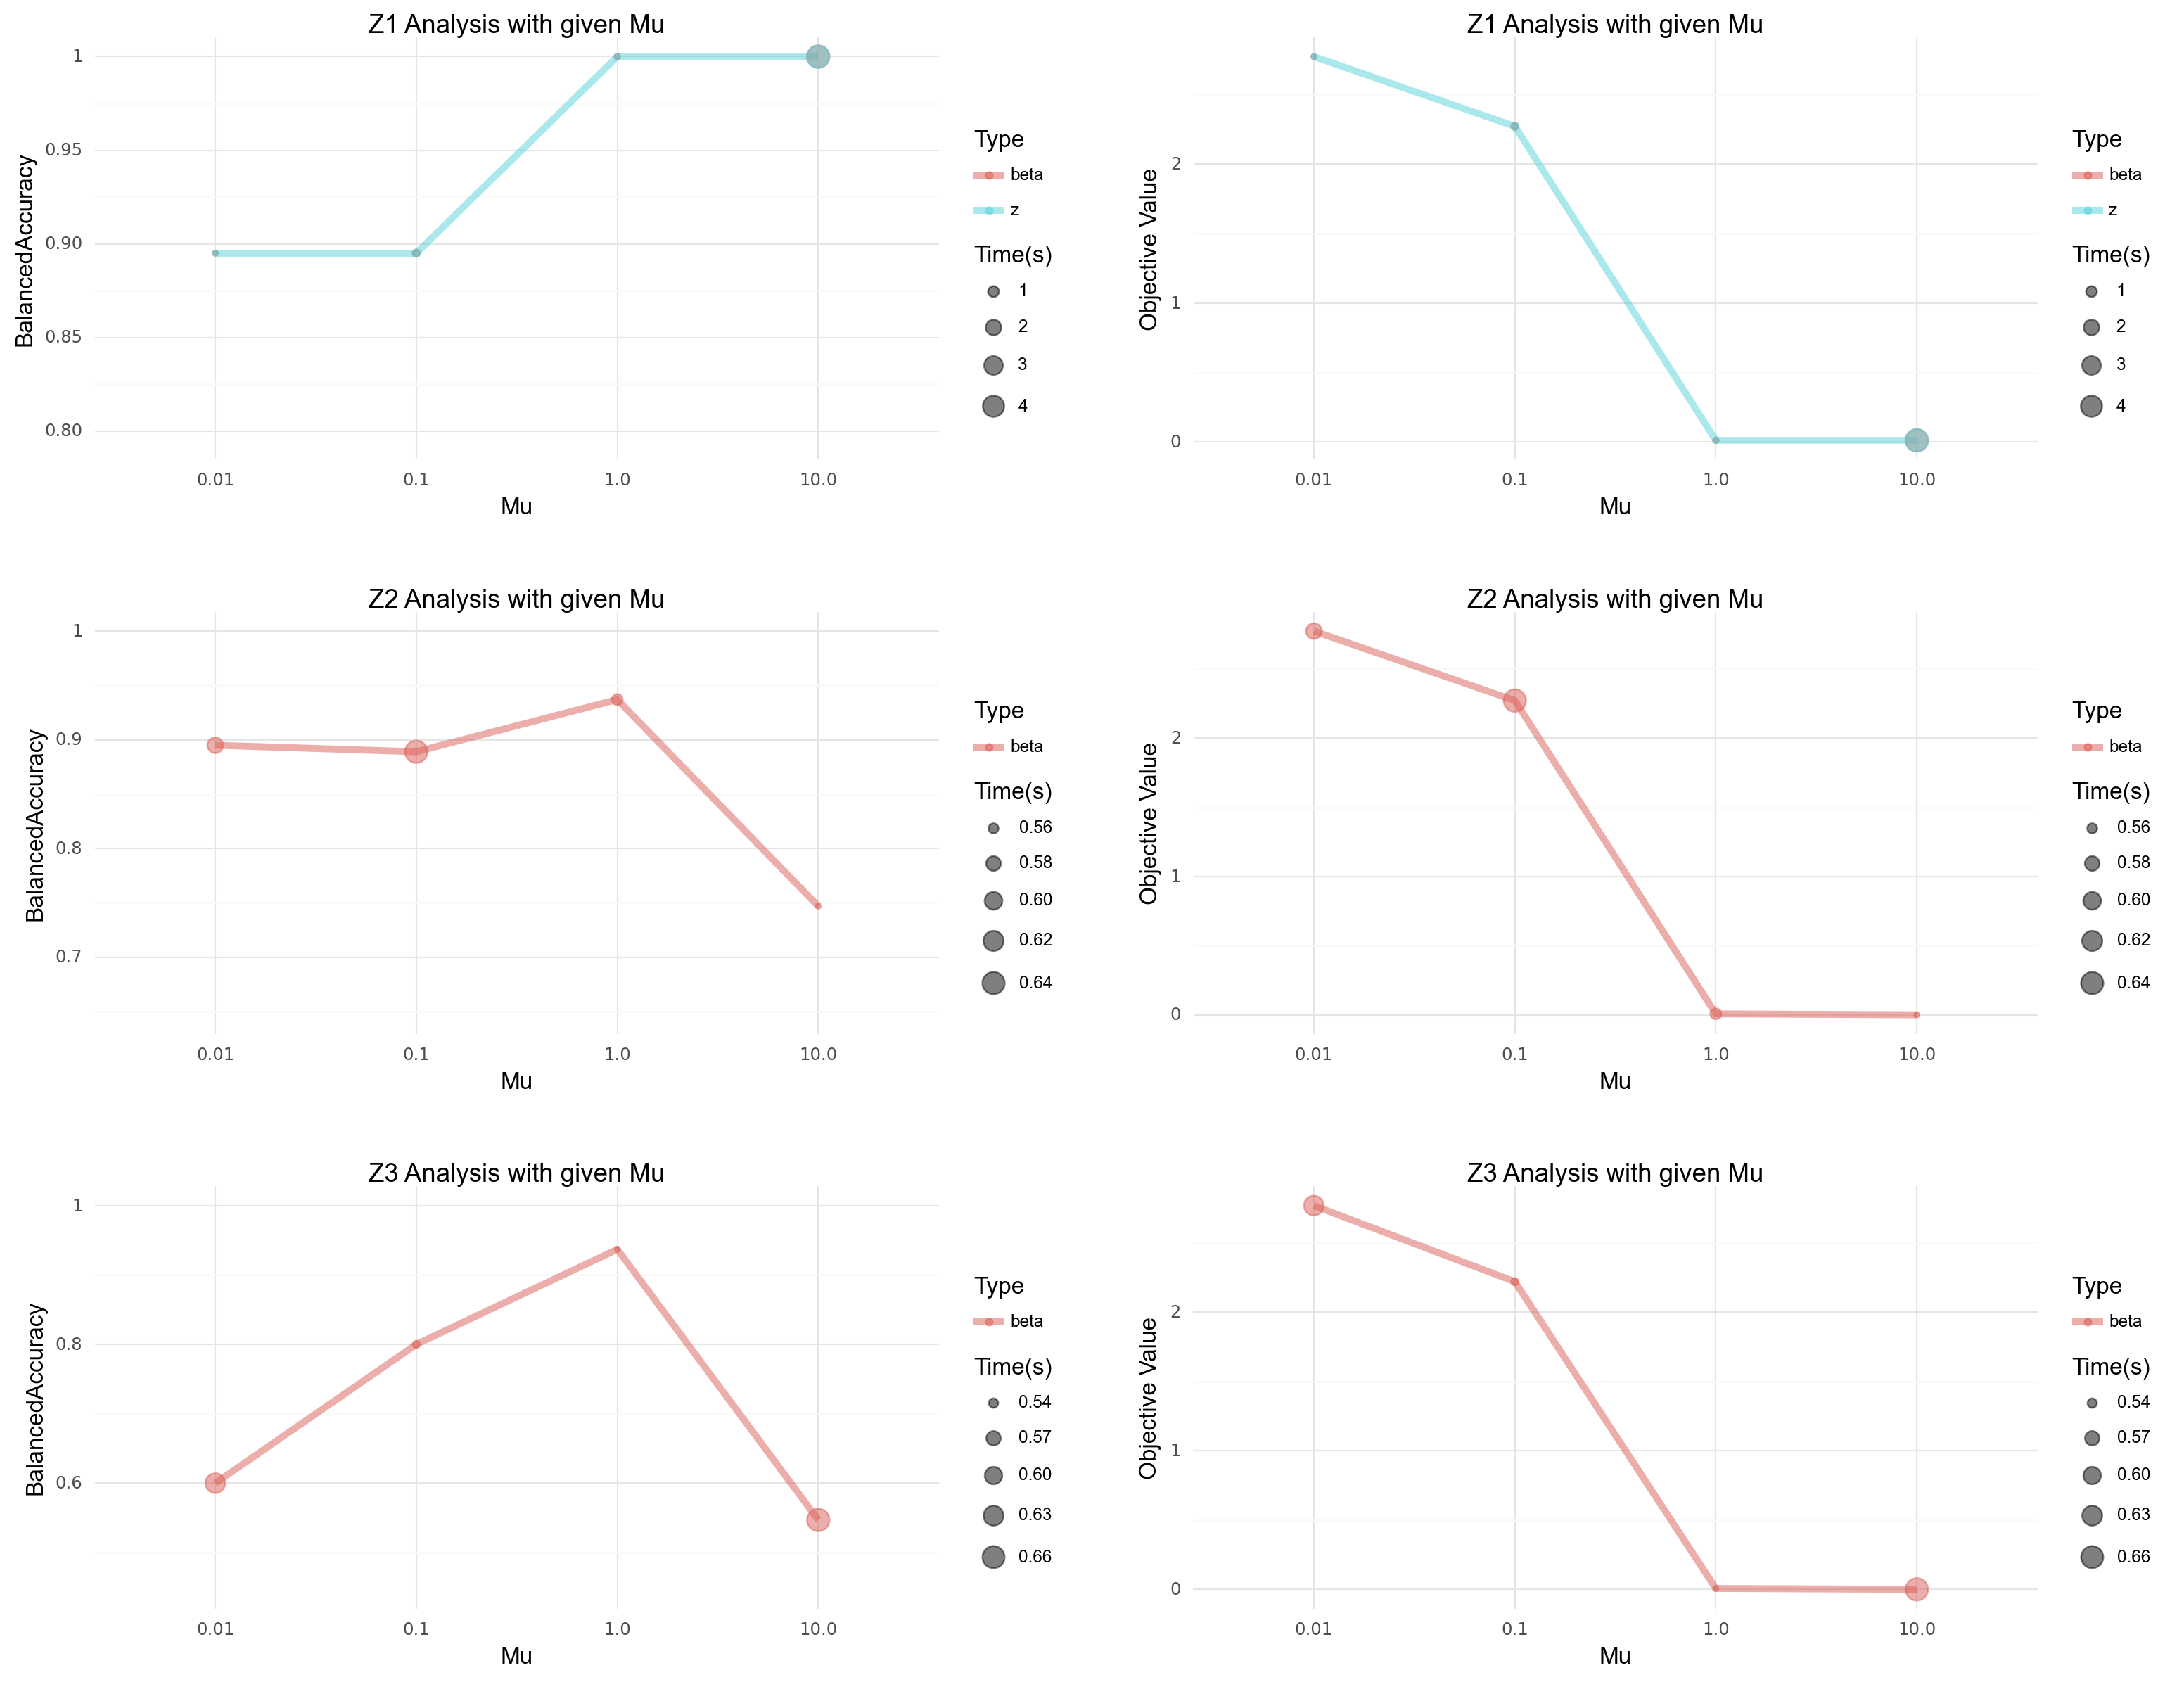

In [93]:
plot_z_experiments(results2)

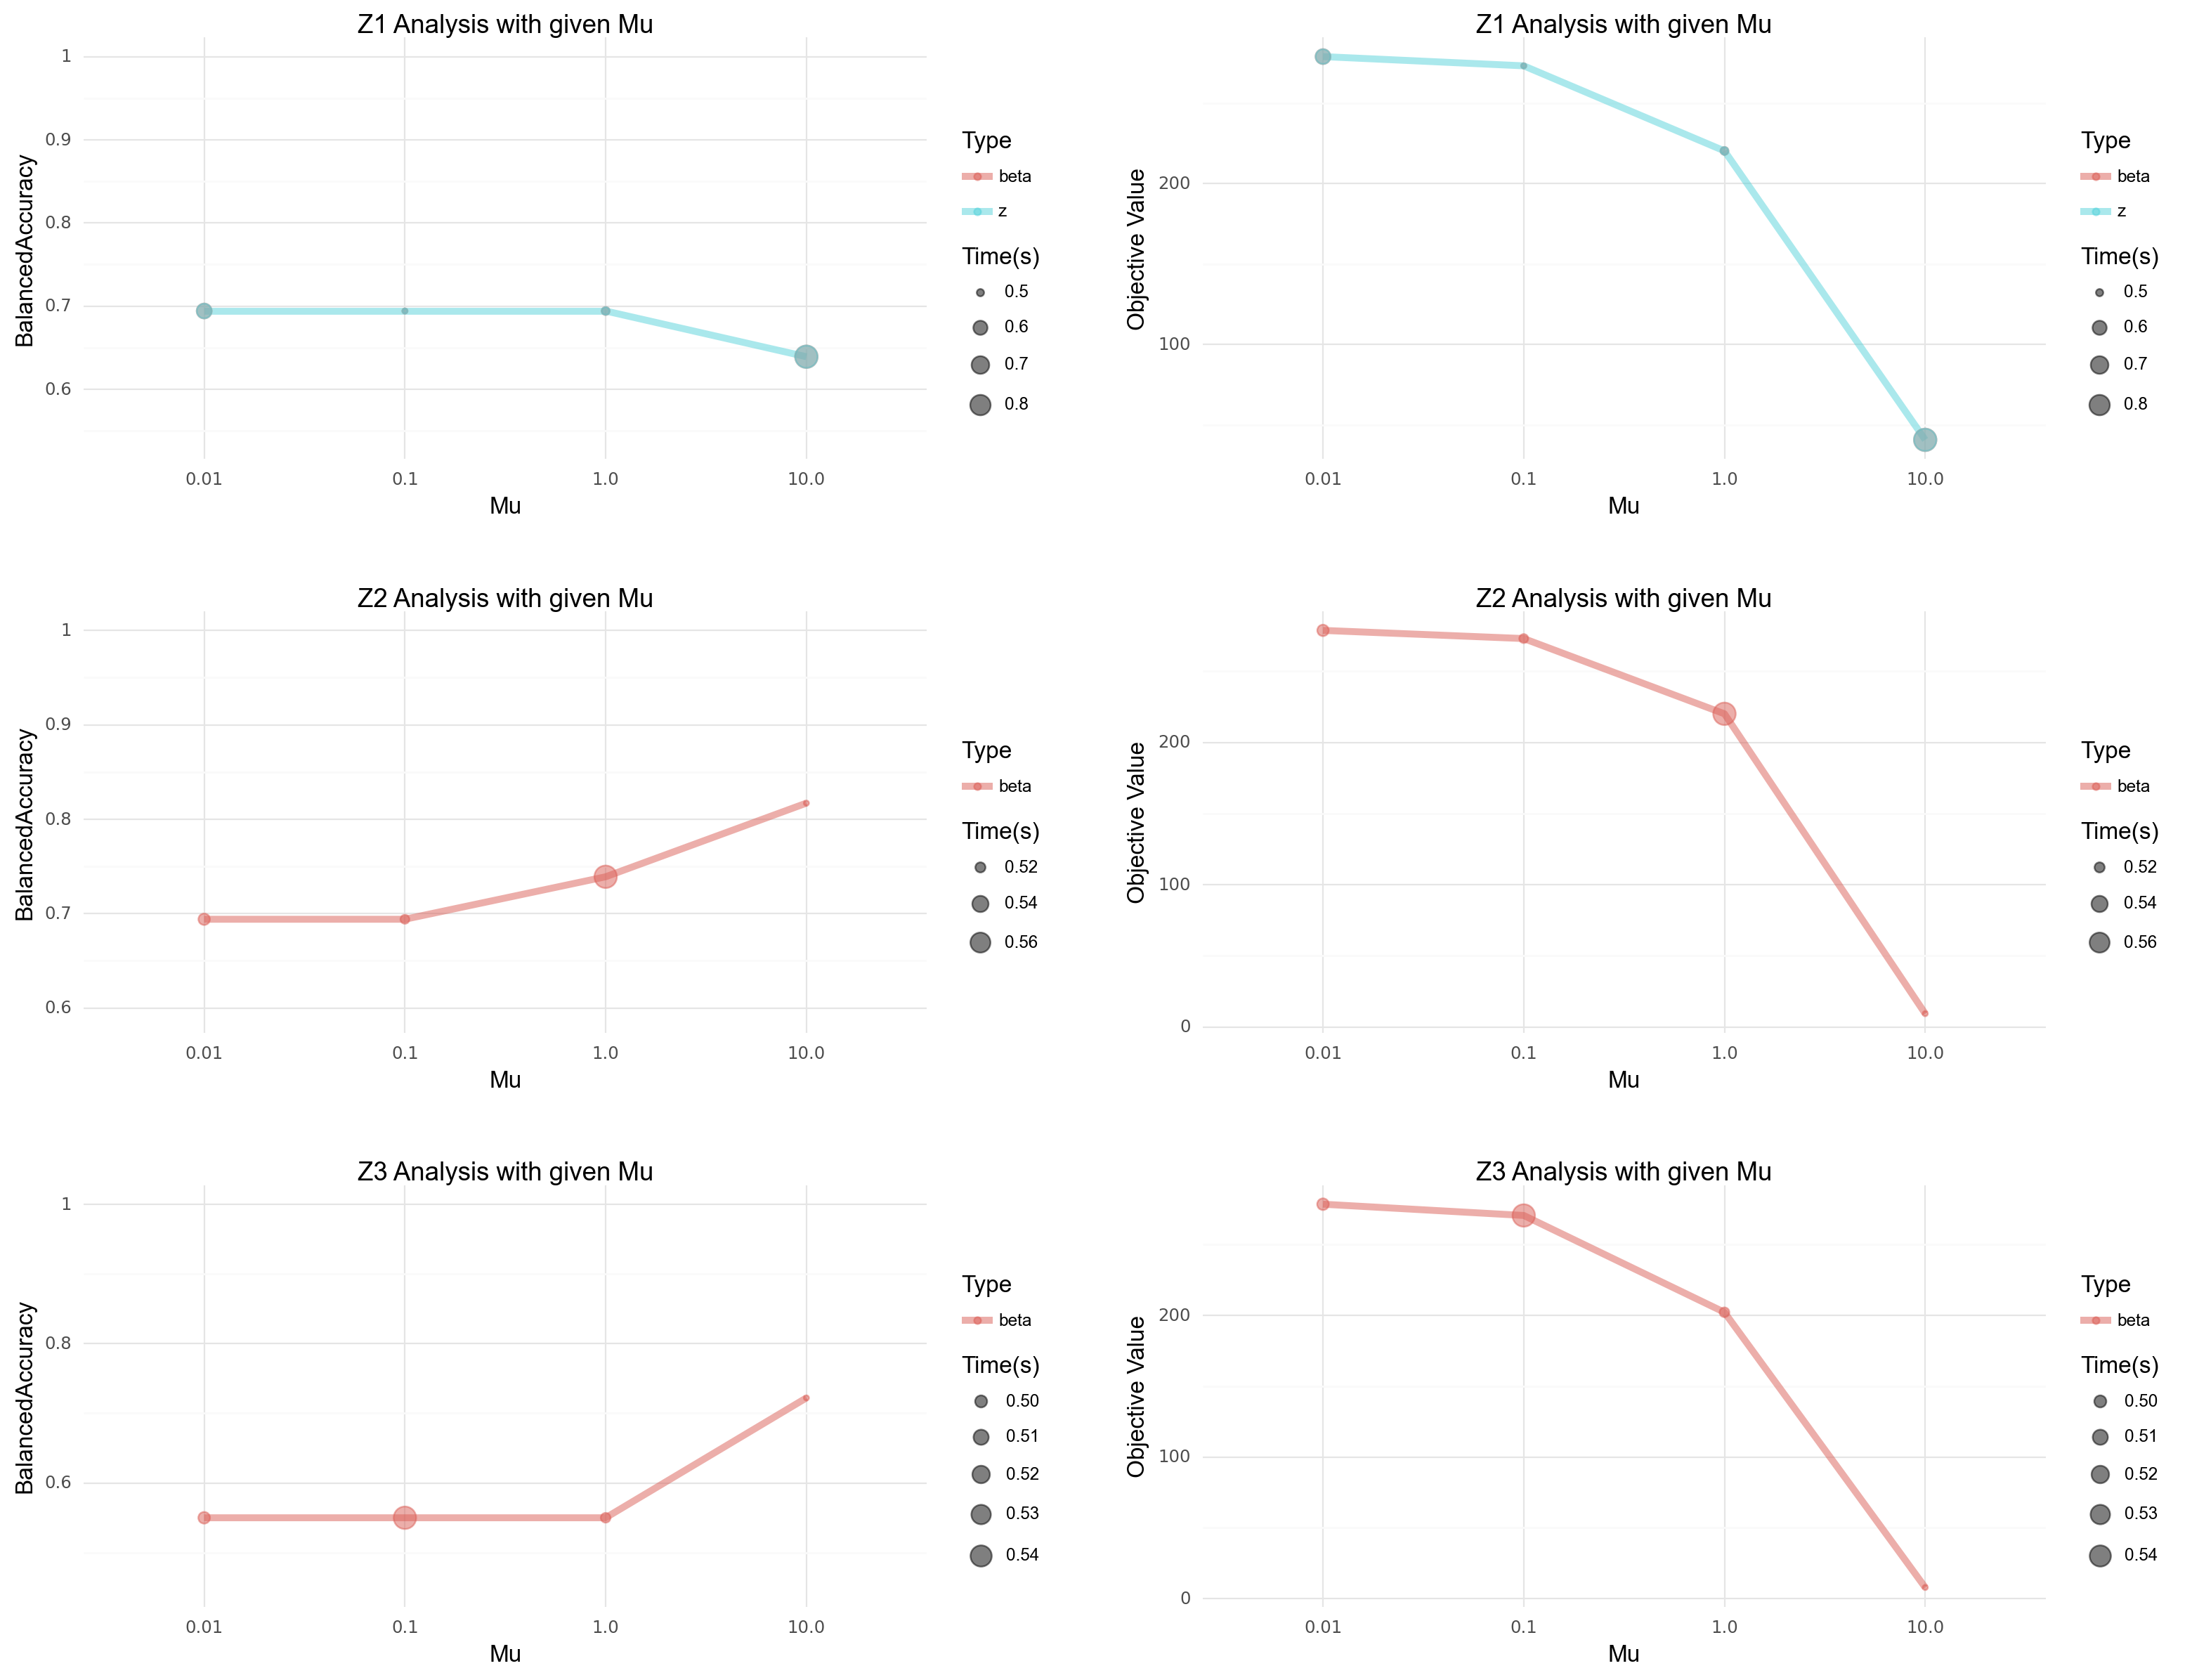

In [71]:
plot_z_experiments(results3)

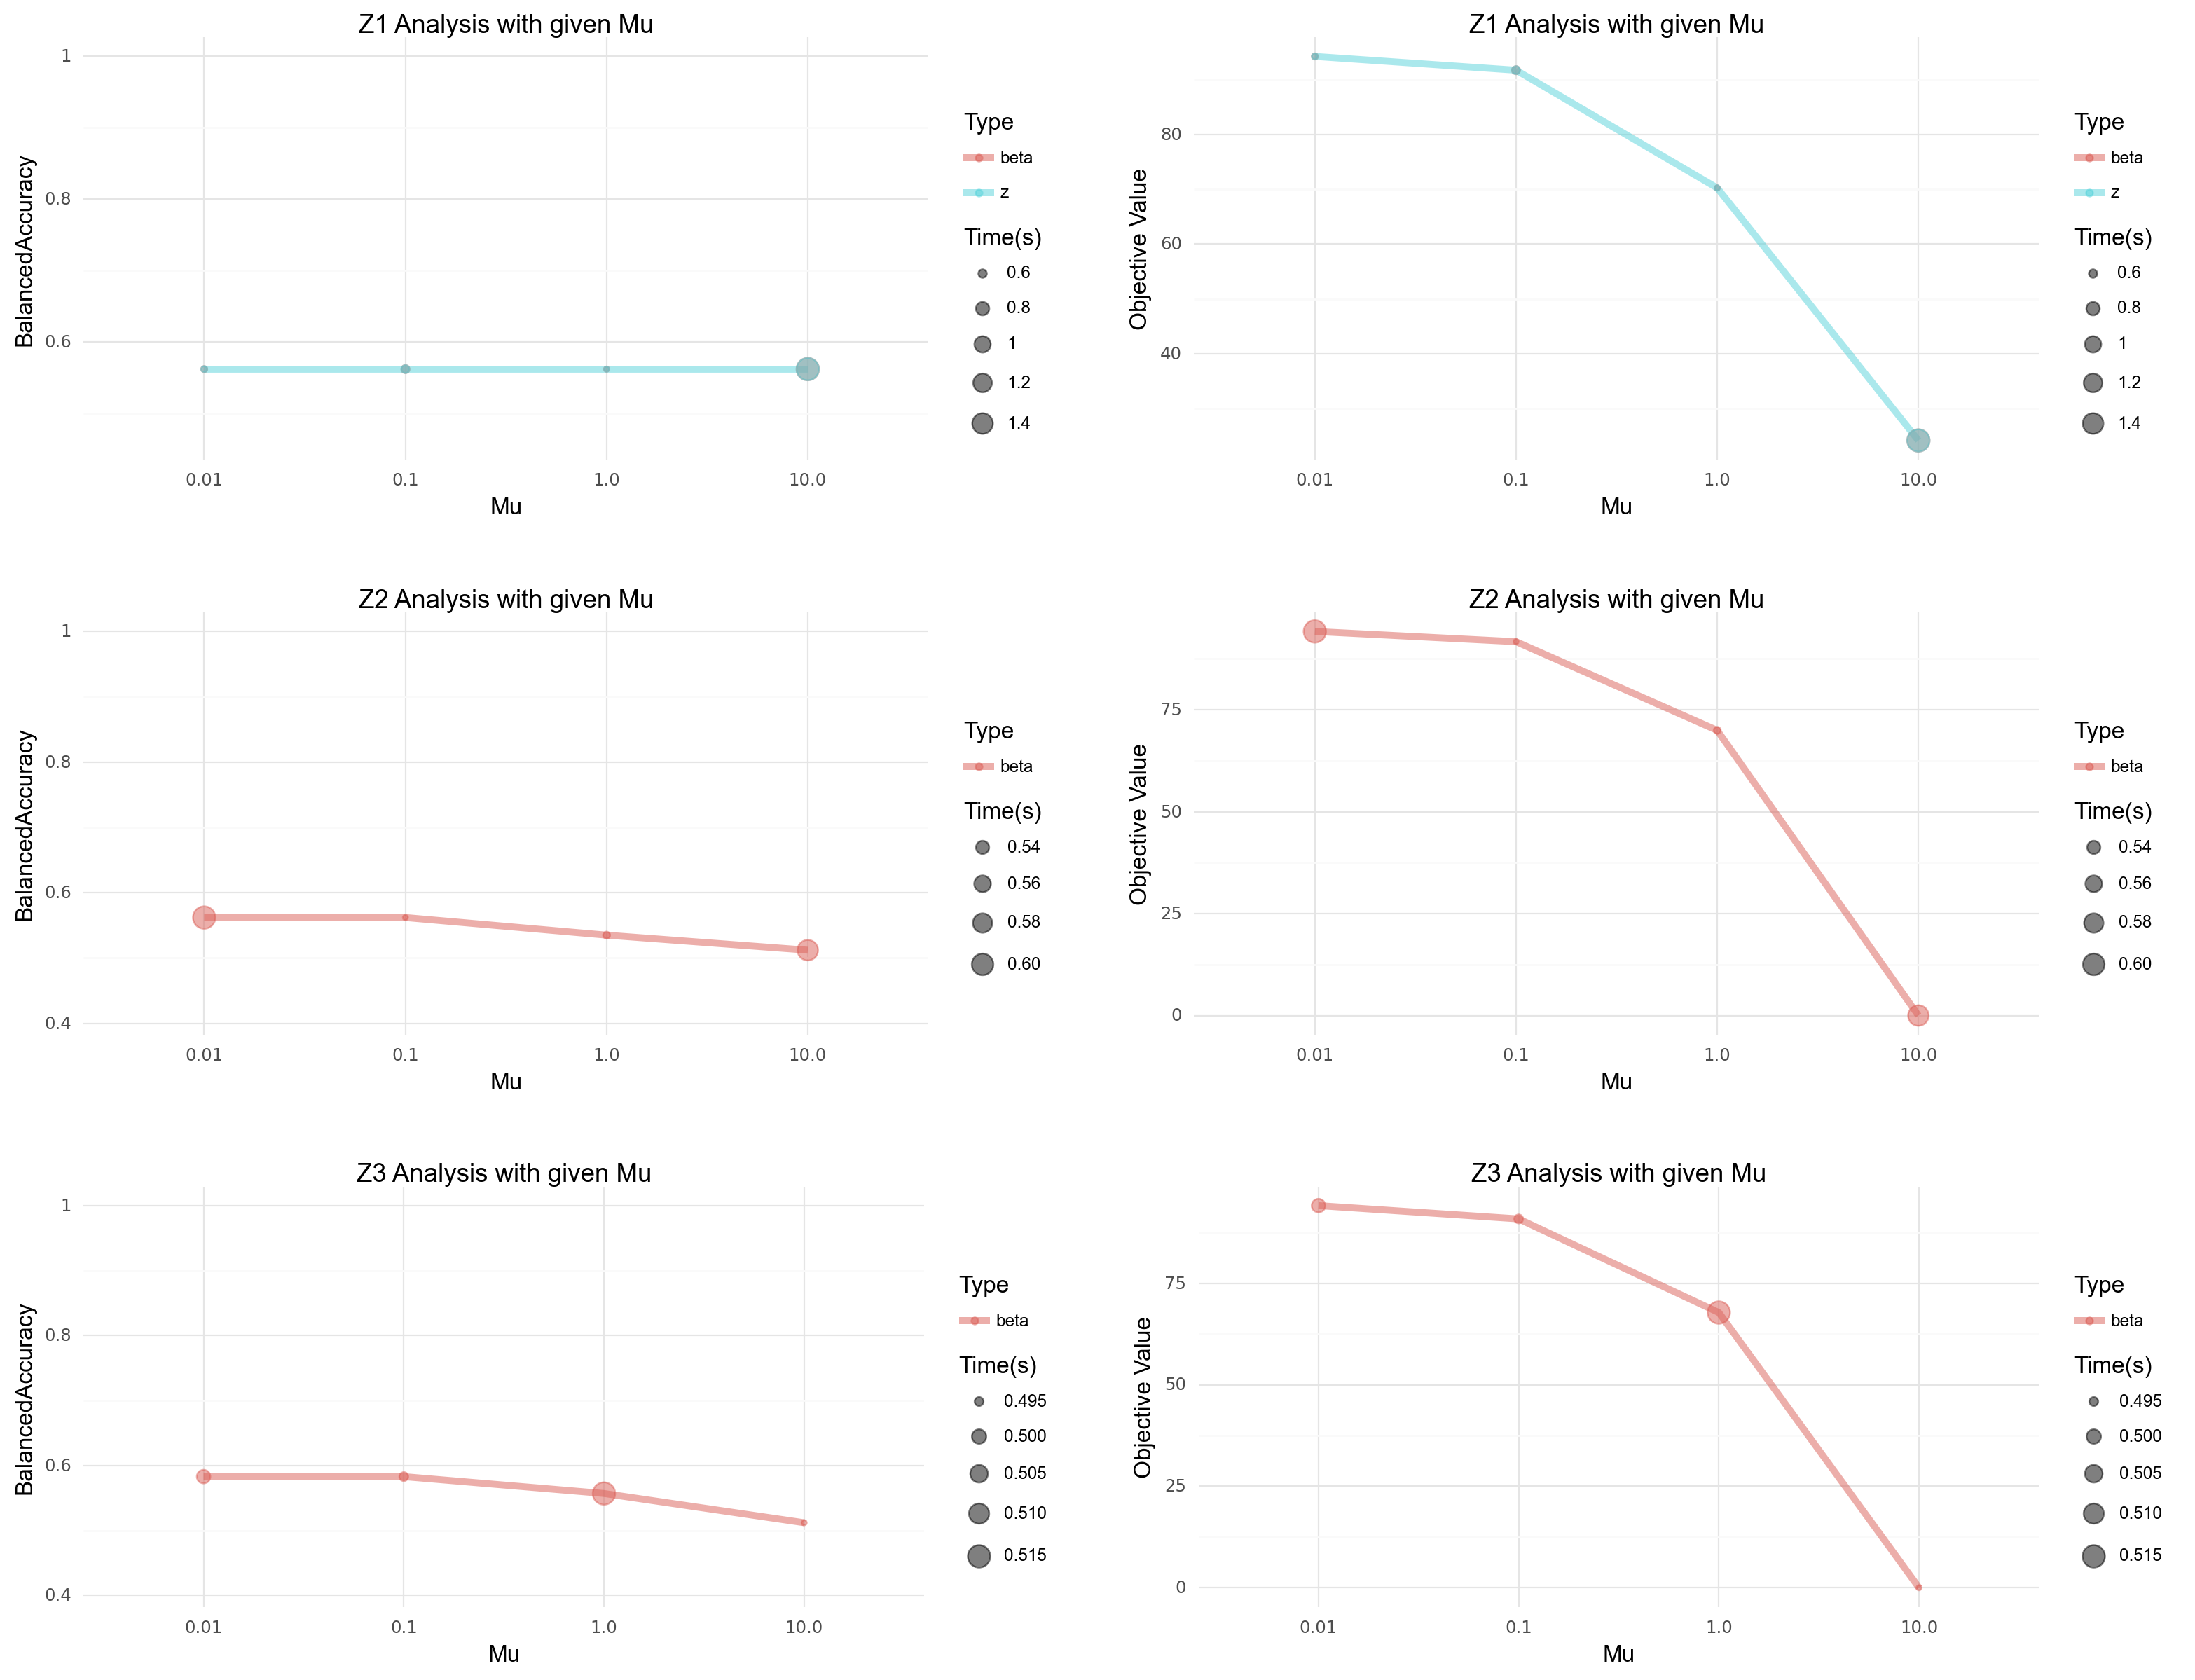

In [94]:
plot_z_experiments(results4)

# SOS1 characteristic

No characteristic as the method is a non-parametrical one.

# SOS2 Characteristic

In this case we will base only on the results from a major experiment, and we will show the heatmap characteristic of BA for betas, zs, and objective function scores for each experiment. Additionally we will show a heatmap of execution times.

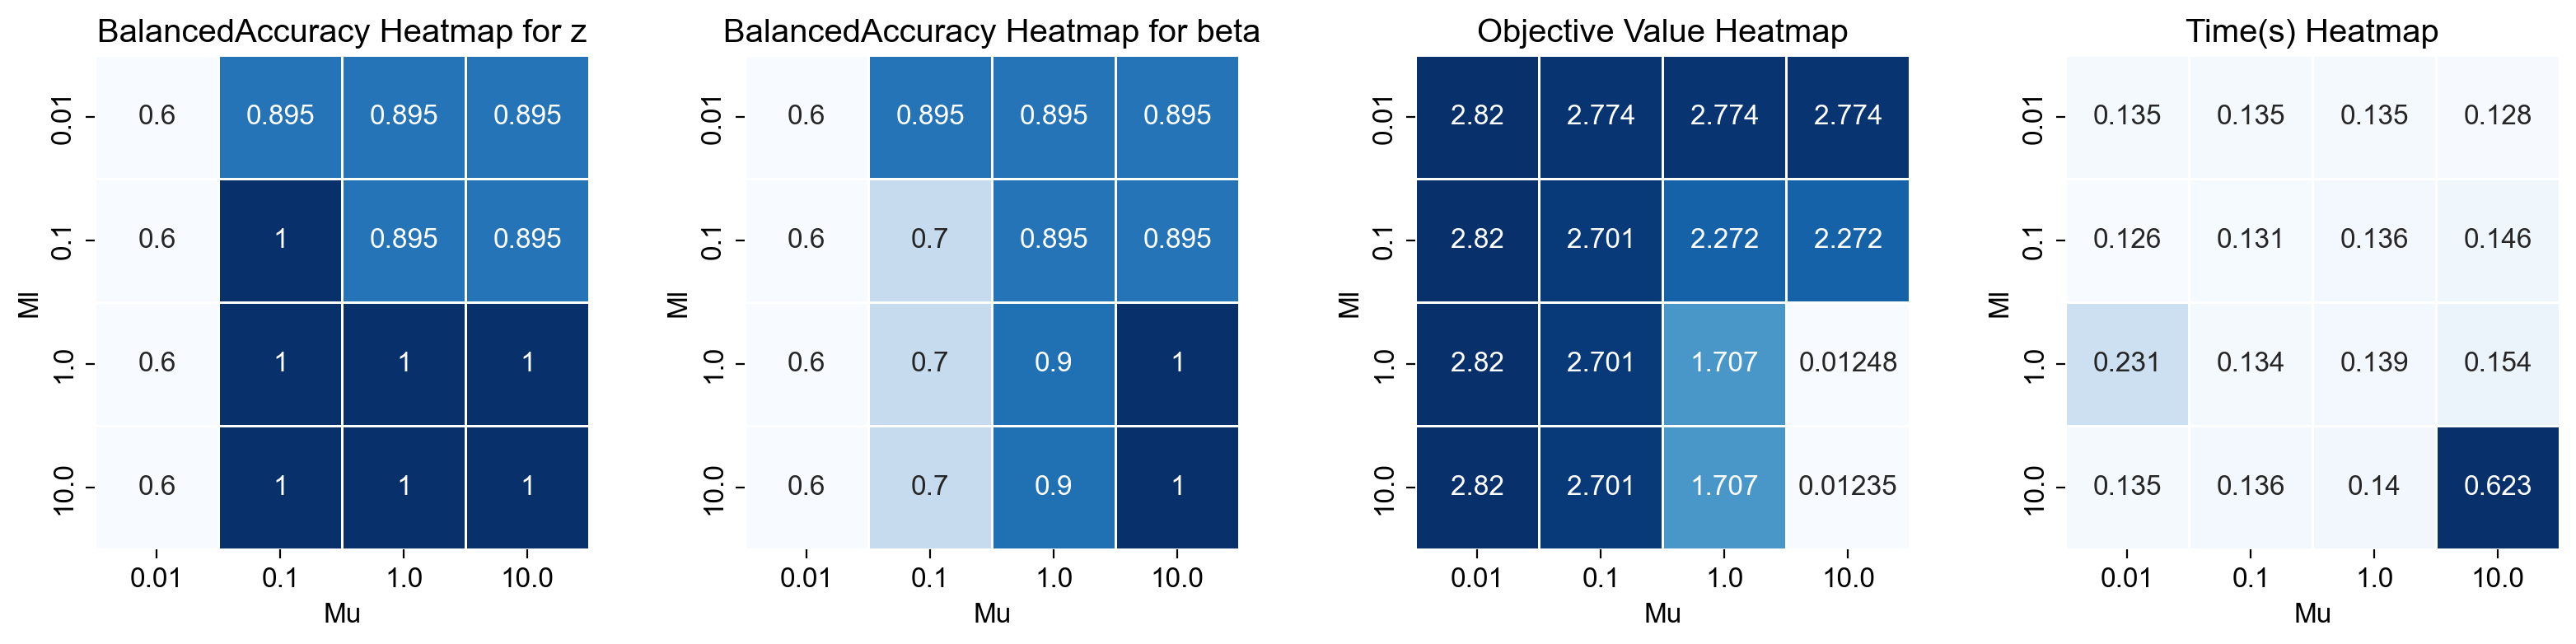

In [73]:
plot_sos2_experiment(results2)

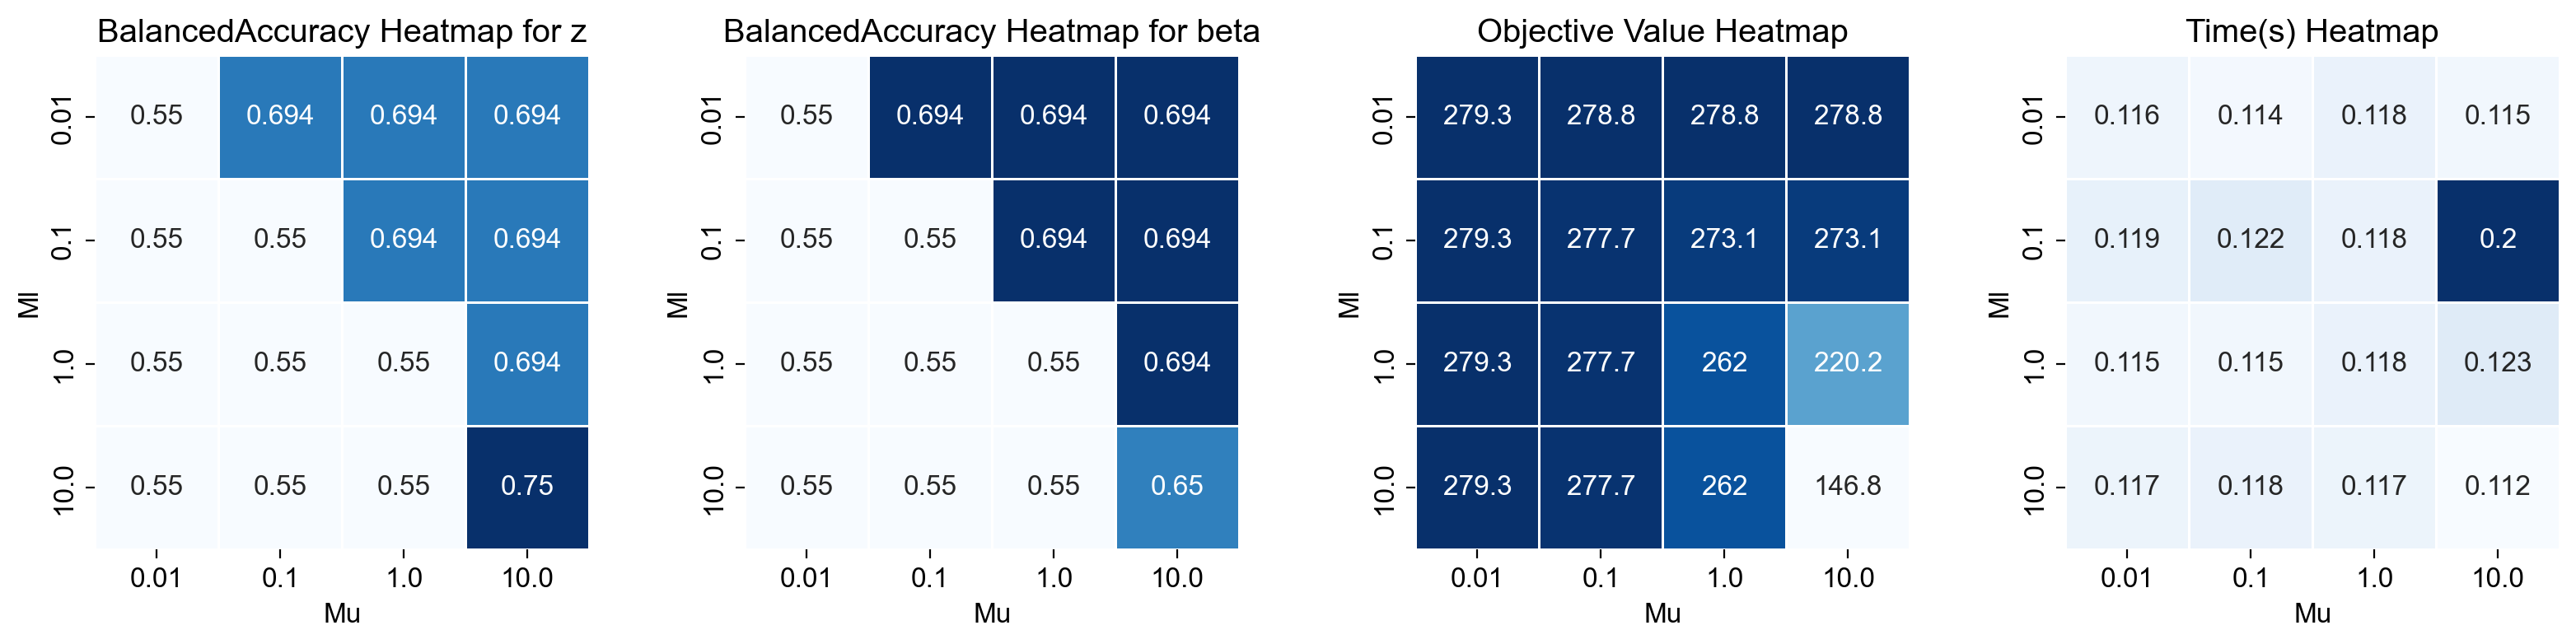

In [74]:
plot_sos2_experiment(results3)

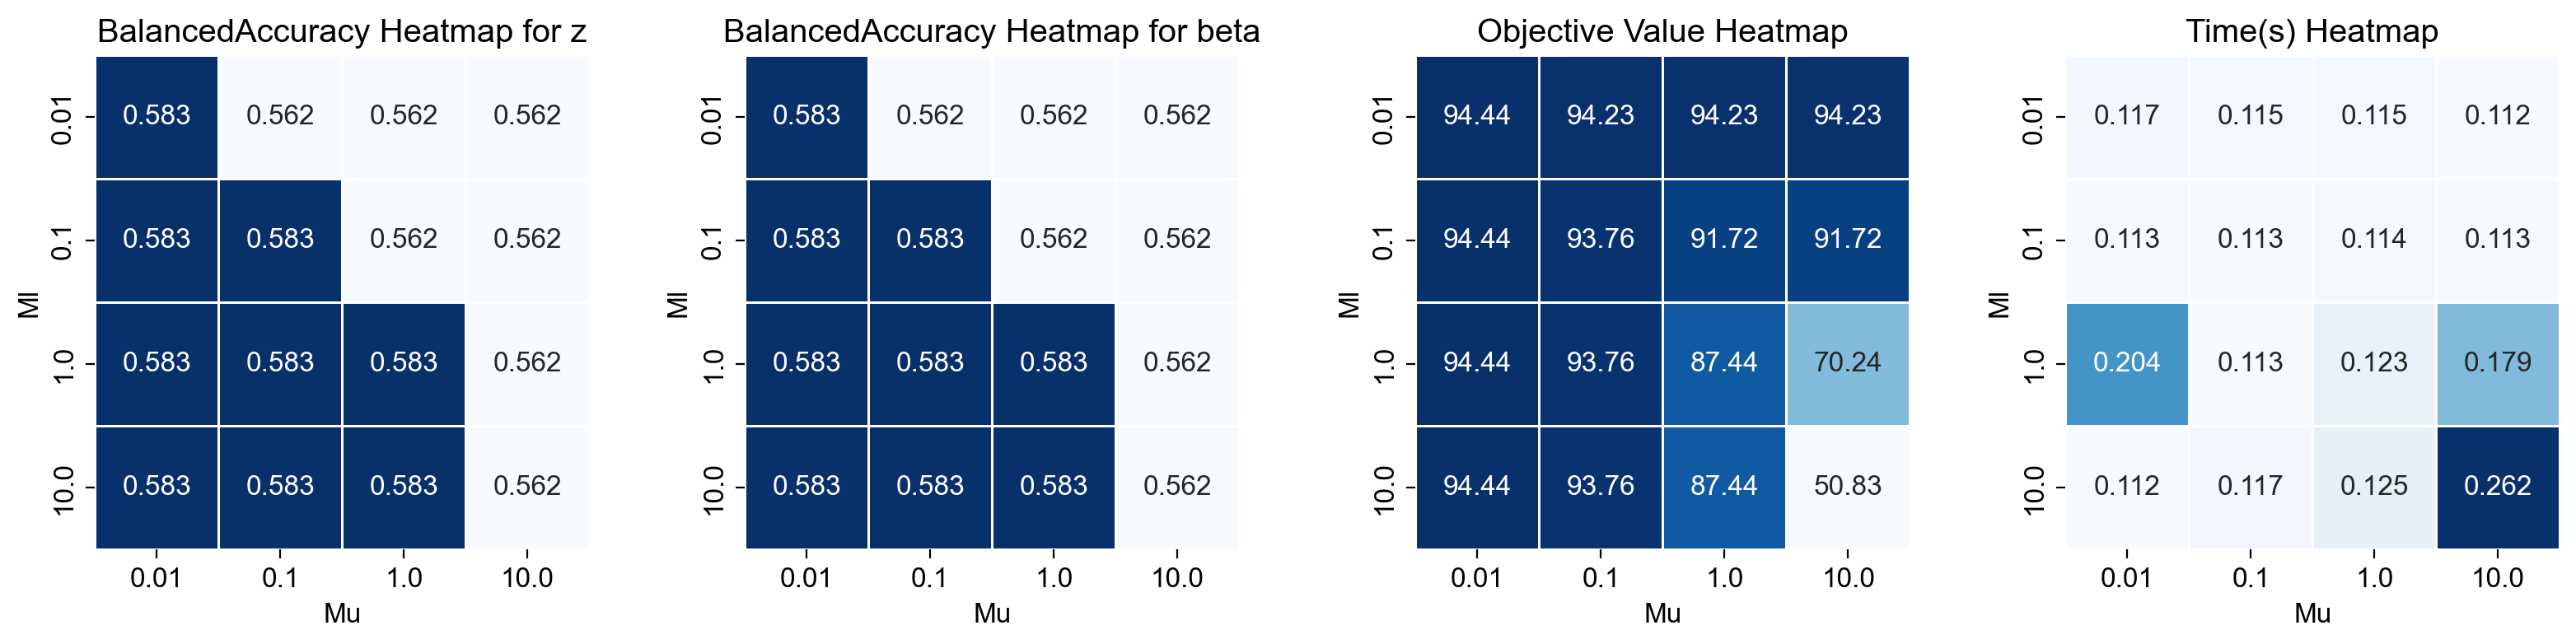

In [75]:
plot_sos2_experiment(results4)

# SOS3 and Final method characteristics

For these 4-hyperparameter plains we are unable to plot a heatmap depending on the parameters as we would have 5 dimensions. For this sake we will analyse the impact by getting the observation with best results for the method (highest BA for betas) and check parameters Mu, Ml, Mu_ksi, and Ml_ksi one at the time with fixed best values for the other params. For each dataset (3 of them) and each method (2 of them) we will analyse all params (4 of them) with 7 values (0.01, 0.05, 0.1, 0.5, 1, 5, 10) and the limit of 60s per single optimization problem (it will last up to 3 hours). 

The outcoming visualizations will be multiple lineplots saparate for each data set. The methods will be shown aon different plots, and the different parameter characteristics will differ in color. The evaluation points sizes will be scaled with the duration in seconds of the calculation of the method. We will do separate plots for the objective functions values.

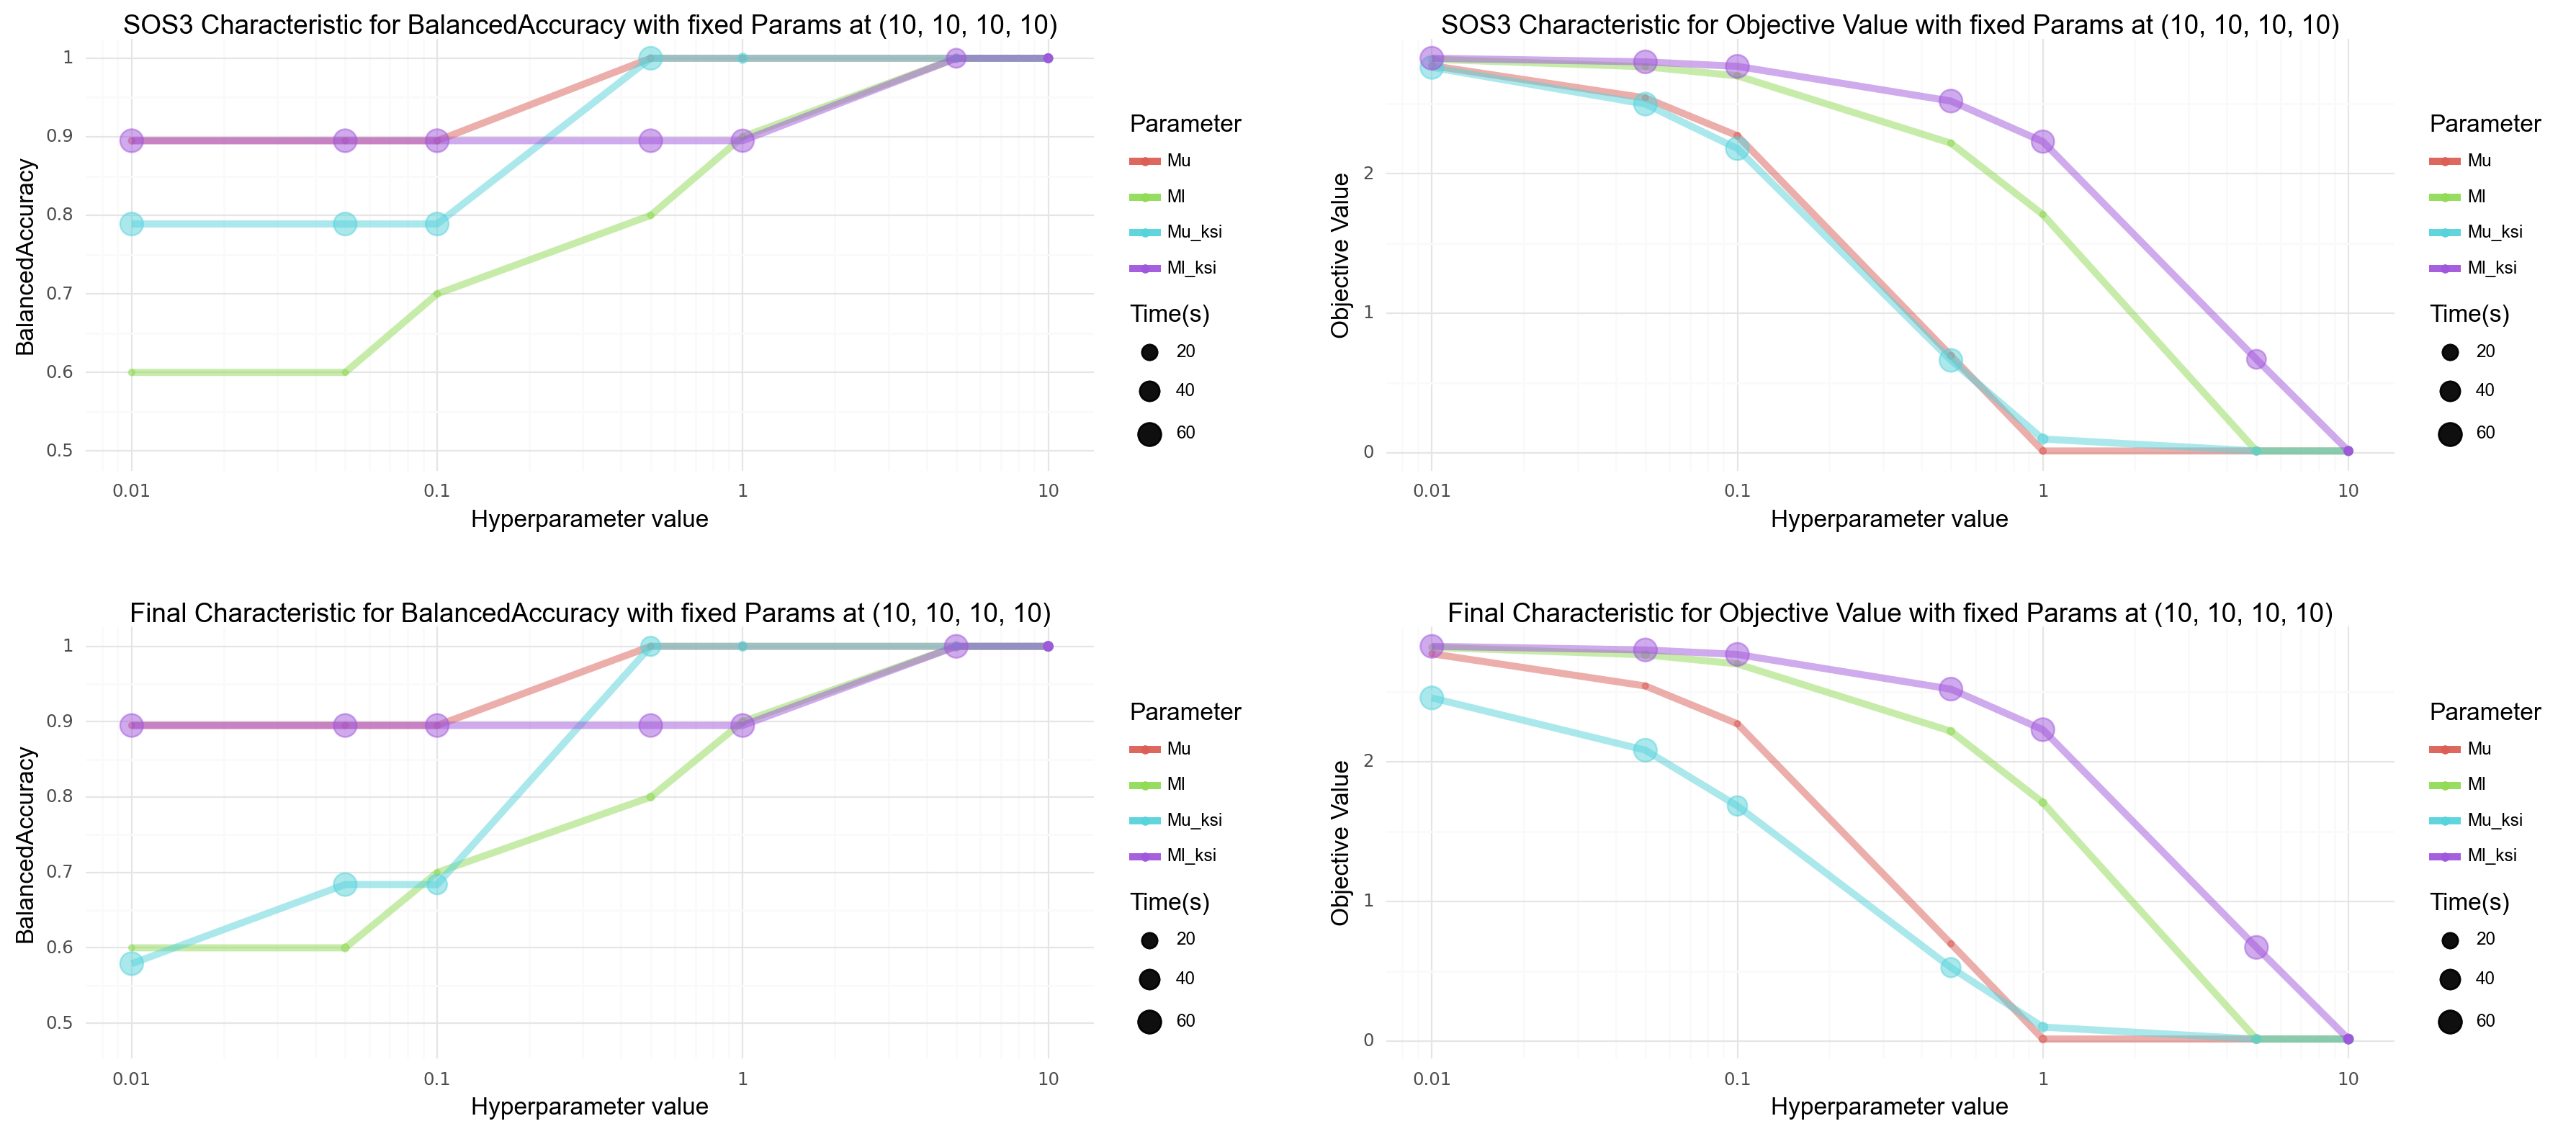

In [95]:
plot_line_study_experiments(sos3_study_2, final_study_2, extensional_results_2)

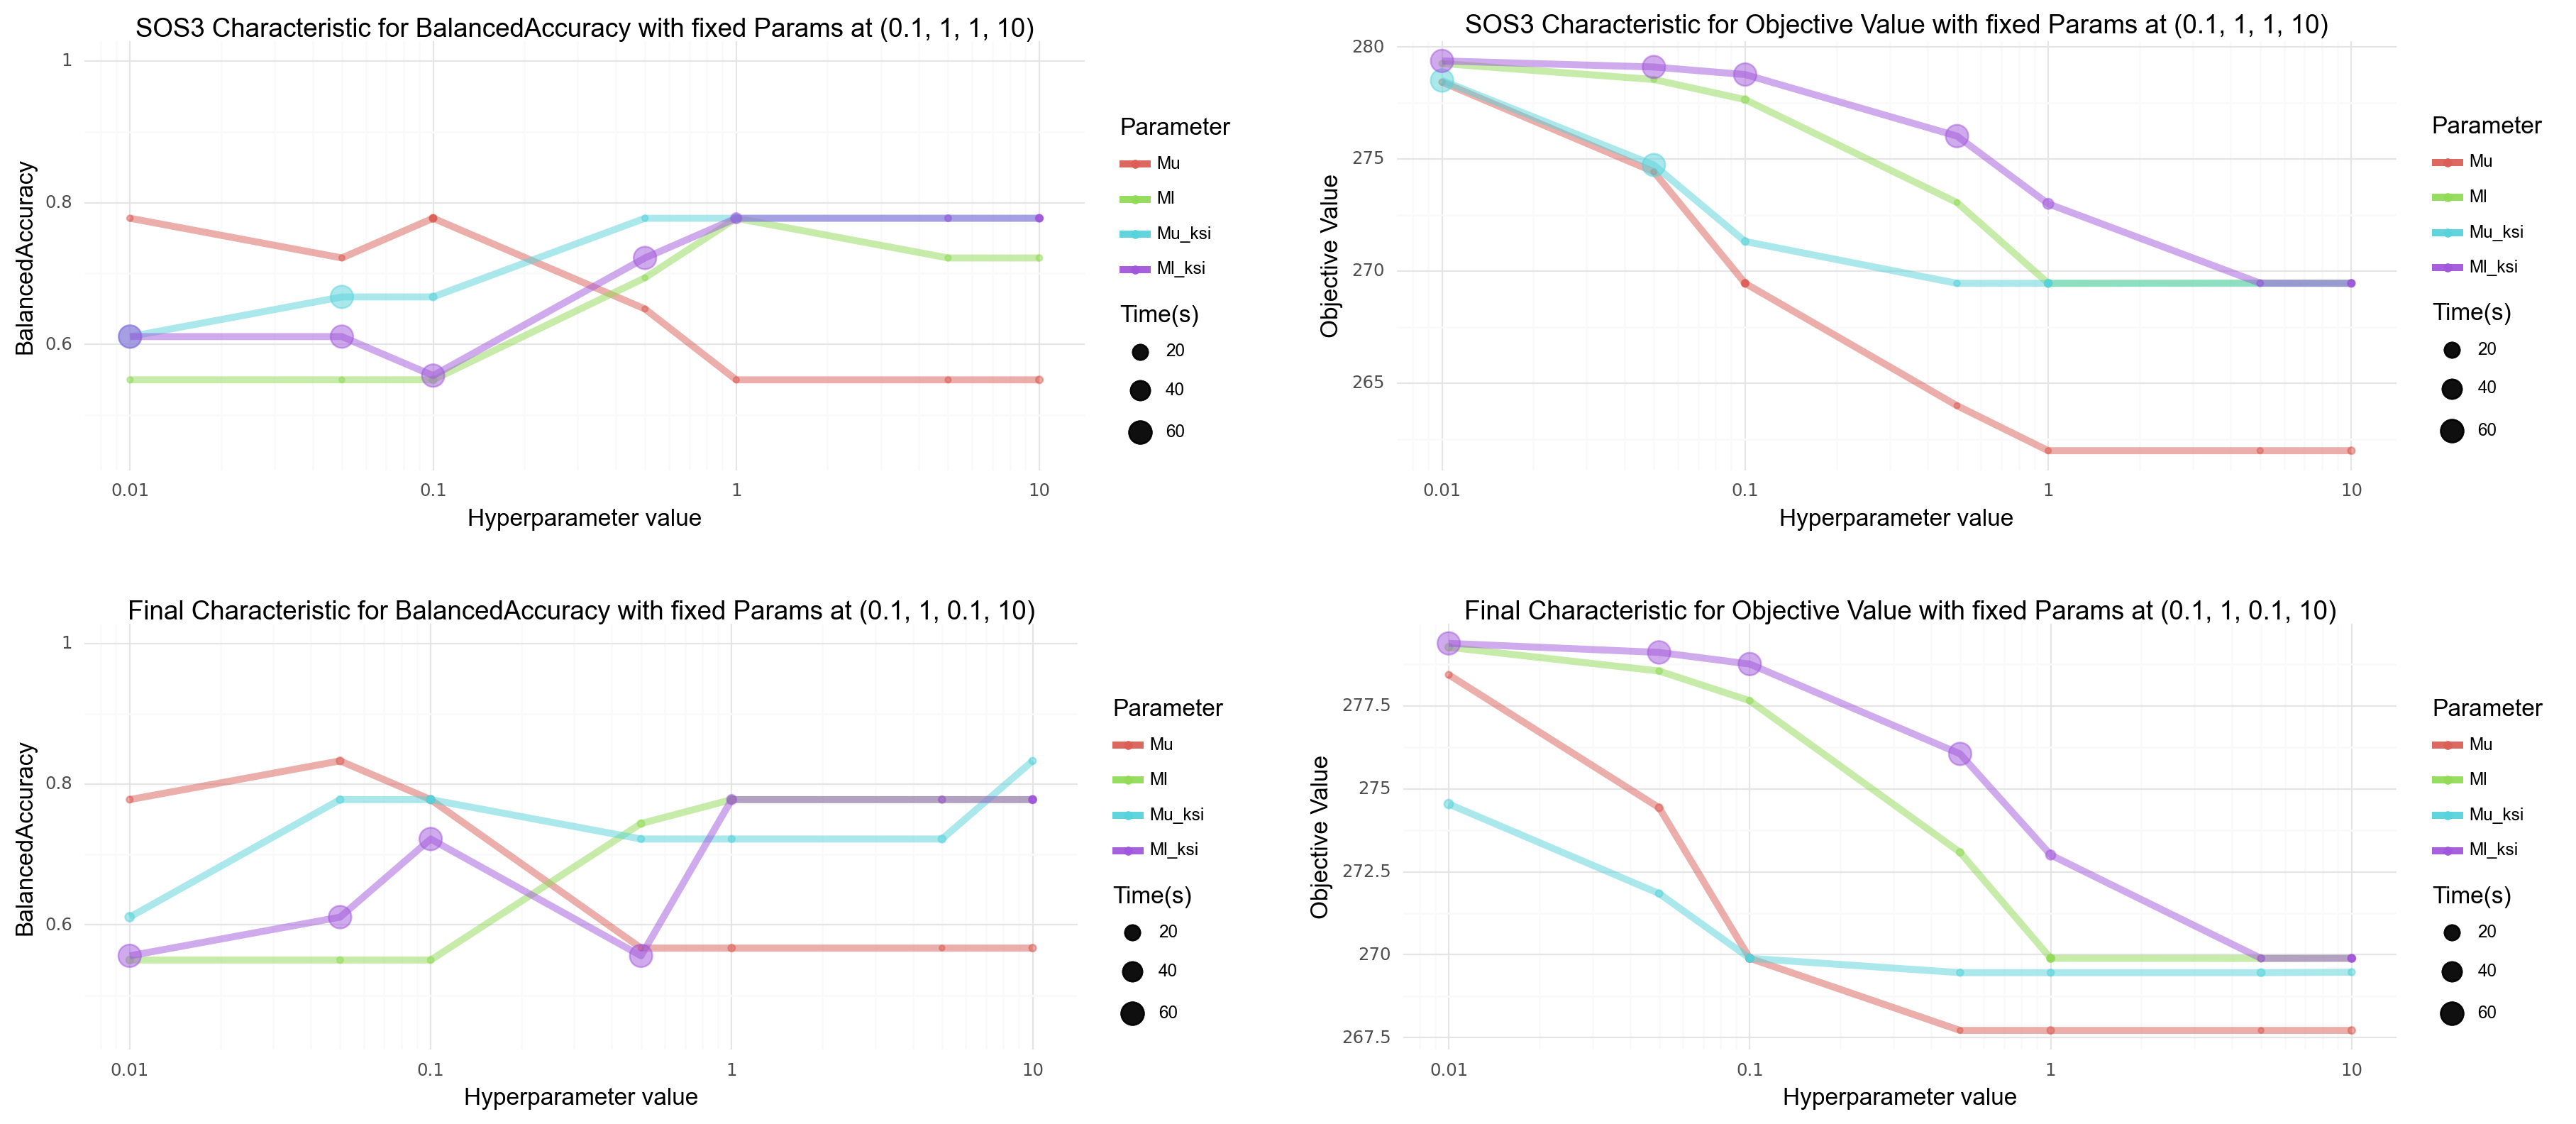

In [96]:
plot_line_study_experiments(sos3_study_3, final_study_3, extensional_results_3)

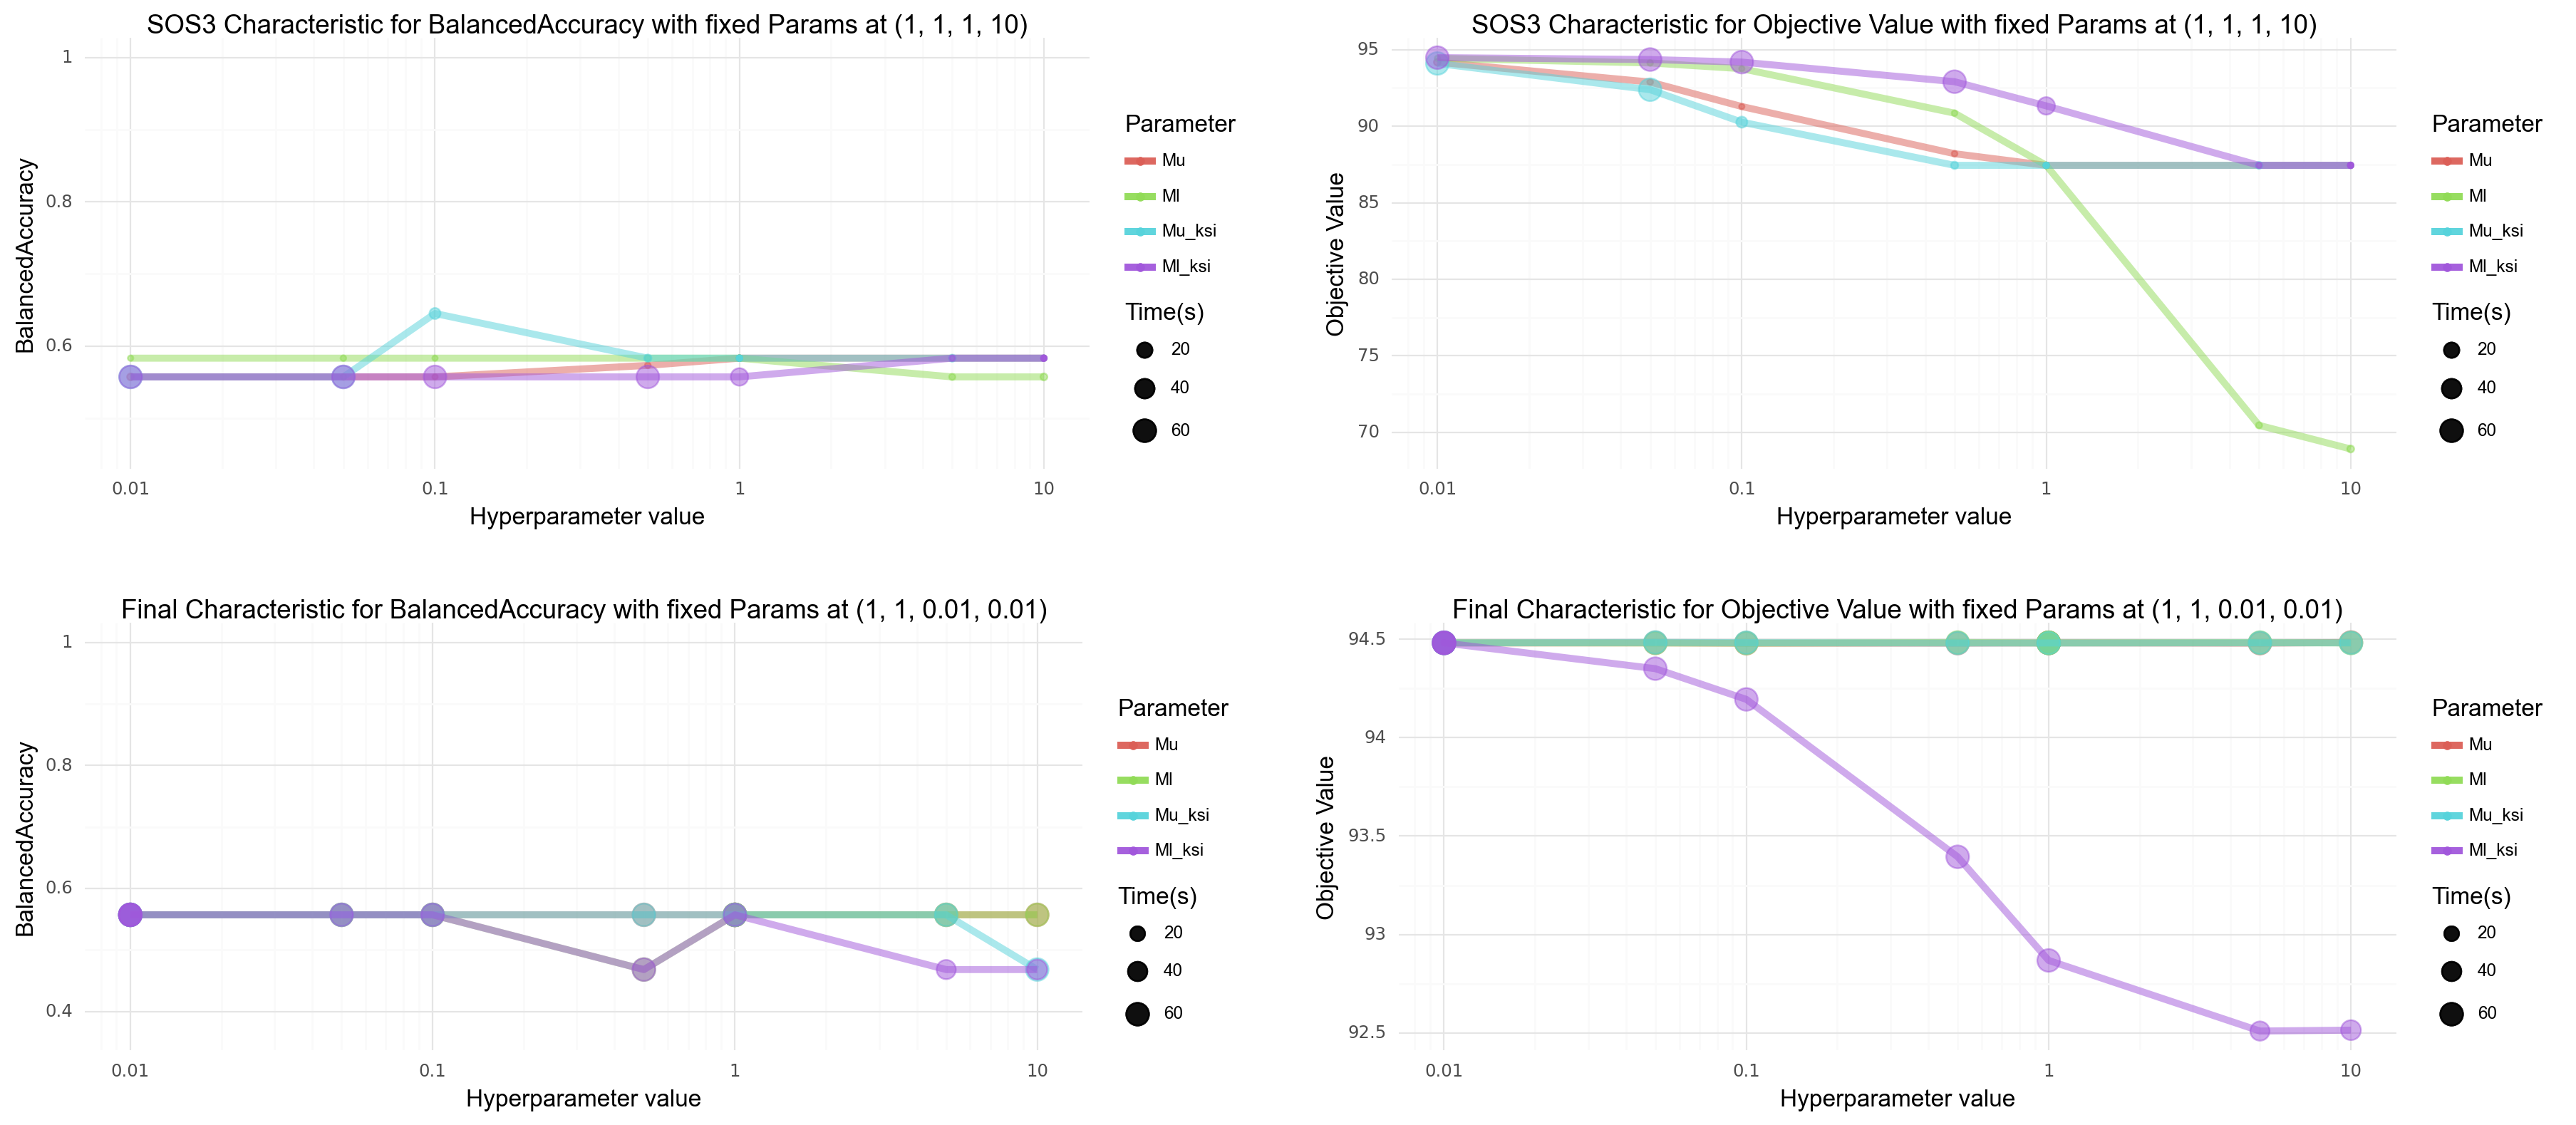

In [97]:
plot_line_study_experiments(sos3_study_4, final_study_4, extensional_results_4)